In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys
import glob
import os
from Bio.Seq import Seq

sys.path.append("../../scripts")
%aimport initial_map
%aimport map_refiner
%aimport complexity
%aimport finder
%aimport preprocess
%aimport complexity
%aimport plotting
%aimport umi_deduplicate

from tqdm import tqdm  # progress bar

# Control variables

In [13]:
# UPDATE list of files and output location
AD_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/L4/TL4_results/data/RNA/a*")
RT_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/L4/TL4_results/data/RNA/r*")
output_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist" # May need to change to your directory due to writing permissions

# Change below as needed to update barcode info, csv path to final step1 map, and desired output directory


step1_ADBC2 = finder.Barcode(name = "ADBC2",
                       preceder = "TATGCTAT",
                       post = "GGCCGGCCG",
                       length = 6)

step1_HawkBCs = finder.Barcode(name = "HawkBCs",
                       preceder = "TAGC",
                       post = "CTCGAGA",
                       length = 9)

step1_RTBC = finder.Barcode(name = "RTBC",
                       preceder = "GCCCC",
                       post = "GCGG",
                       length = 16)

# Step 1 map
step1_csv = "../../output/NKX2-2_whitelist_step1_map.csv"  # Step 1 map I made with error correcting 

In [4]:

# PReviously using wrong below
# step1_ADBC2 = finder.Barcode(name = "ADBC2",
#                        preceder = "TGCTAT",
#                        post = "GGCCGGCC",
#                        length = 6)

# # Example DNA sequence
# seq = Seq("GCTA")  # includes ambiguous bases

# # Reverse complement
# rev_comp = seq.reverse_complement()

# print(rev_comp)  # Output: YRNACGGCAT

# From CC (Need to take rc to work with my code)

# ADBC2
# bc2_pre="CGGCCGGCC", 
# bc2_post="ATAGCATA", 

# Hawk
# bc1_pre="TCTCGAG", 
# bc1_post="GCTA"):


# pre: CCGC
# post: GGGGC


# First, AD analysis

In [14]:
db_path = os.path.join(output_path, "NKX2-2_CC_UMI_whitelisted.db")

In [15]:
AD_objects = [step1_ADBC2, step1_HawkBCs]

In [16]:
complex_AD_results = []
simple_AD_results = []

In [8]:
for file_path in AD_seq_files:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0]
    print(name_only) 

    # Get the file naeme to use for output
    umi_path = os.path.join(output_path, f"umi_{name_only}")
    print(umi_path)

    # Extract UMIs and barcodes from reads
    umi_mapper = initial_map.InitialMapper(db_path = db_path,
                                       step_name = f"umi_{name_only}", 
                                       seq_file = file_path,
                                       design_file_path = None,
                                       bc_objects = AD_objects,
                                       reverse_complement = True,
                                       umi_length = 12)
    umi_mapper.create_map()

    print("whitelisting")
    umi_mapper.apply_whitelist(umi_path)

    print("refining")
    # Only keep barcodes of correct length
    refiner = map_refiner.MapRefiner(db_path = db_path,
                                        bc_objects=AD_objects,
                                        column_pairs = [],
                                        reads_threshold = 1,
                                        map_order = ['quality_designed'],
                                        step_name=f"umi_{name_only}", 
                                        descriptor = "")
    refiner.refine_map_from_db()

    

    # Run both deduplications
    deduplicator = umi_deduplicate.UMIDeduplicator(db_path = db_path,
                                                        bc_objects = AD_objects,
                                                        step_name = f"umi_{name_only}", 
                                                        descriptor = "",
                                                        step1_map_name = None,
                                                        fastq_path = file_path,
                                                        umi_length = 12,
                                                        output_path = umi_path)

    deduplicator.run_both_deduplications()

    # Collect results
    one_file_complex_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_directional_umi_counts.tsv"), sep = "\t")
    one_file_complex_results["name"] = name_only
    complex_AD_results.append(one_file_complex_results)

    one_file_simple_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_simple_umi_counts.tsv"), sep = "\t")
    one_file_simple_results["name"] = name_only
    simple_AD_results.append(one_file_simple_results)

a2_RNA_ADBC_S18
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_a2_RNA_ADBC_S18
a7_RNA_ADBC_S23
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_a7_RNA_ADBC_S23
a1_RNA_ADBC_S17
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_a1_RNA_ADBC_S17
a3_RNA_ADBC_S19
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_a3_RNA_ADBC_S19
a6_RNA_ADBC_S22
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_a6_RNA_ADBC_S22
a4_RNA_ADBC_S20
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_a4_RNA_ADBC_S20
a8_RNA_ADBC_S24
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_a8_RNA_ADBC_S24
a5_RNA_ADBC_S21
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/outpu

In [18]:
all_complex_AD_results_df = pd.concat(complex_AD_results)
all_complex_AD_results_df = all_complex_AD_results_df.rename(columns = {"count" : "AD_umi_count", "gene" : "ADBC_concat"})
all_complex_AD_results_df["number"] = all_complex_AD_results_df["name"].str[1]
all_complex_AD_results_df

ADBC_concat  AD_umi_count             name number
0     CTGCCACATTATCCG          1024  a2_RNA_ADBC_S18      2
1     CAATAGCAGACAGCA           223  a2_RNA_ADBC_S18      2
2     CCAGGACACCGATTG          1939  a2_RNA_ADBC_S18      2
3     CACTGCCATCCACTA           722  a2_RNA_ADBC_S18      2
4     TACATACAATGTGAC          1823  a2_RNA_ADBC_S18      2
...               ...           ...              ...    ...
1056  TGGGTTCATCCACTA             1  a5_RNA_ADBC_S21      5
1057  AACCAACATTCCAAG             1  a5_RNA_ADBC_S21      5
1058  CTAAATCAGATATGG             1  a5_RNA_ADBC_S21      5
1059  GATGTACAAGACCTA             1  a5_RNA_ADBC_S21      5
1060  AGCACTCACAACTTC             1  a5_RNA_ADBC_S21      5

[7344 rows x 4 columns]

In [19]:
all_complex_AD_results_df.to_csv(os.path.join(output_path, f"all_complex_AD_results.csv"))

In [20]:
all_simple_AD_results_df = pd.concat(simple_AD_results)
all_simple_AD_results_df = all_simple_AD_results_df.rename(columns = {"count" : "AD_umi_count"})
all_simple_AD_results_df["ADBC_concat"] = all_simple_AD_results_df["ADBC2"] + all_simple_AD_results_df["HawkBCs"]
all_simple_AD_results_df["number"] = all_simple_AD_results_df["name"].str[1]
all_simple_AD_results_df

ADBC2    HawkBCs  AD_umi_count             name      ADBC_concat number
0     GGTTAT  CACAACTTC         11920  a2_RNA_ADBC_S18  GGTTATCACAACTTC      2
1     CCATAA  CACCGATTG          8900  a2_RNA_ADBC_S18  CCATAACACCGATTG      2
2     GCCTGT  CACAACTTC          7049  a2_RNA_ADBC_S18  GCCTGTCACAACTTC      2
3     AGACTA  CACAACTTC          6678  a2_RNA_ADBC_S18  AGACTACACAACTTC      2
4     CGAGTC  CACAACTTC          6321  a2_RNA_ADBC_S18  CGAGTCCACAACTTC      2
...      ...        ...           ...              ...              ...    ...
1056  ACGACT  CAGGACTTG             1  a5_RNA_ADBC_S21  ACGACTCAGGACTTG      5
1057  CCCAAT  CATTATCCG             1  a5_RNA_ADBC_S21  CCCAATCATTATCCG      5
1058  AAGCGG  CATCCTGTC             1  a5_RNA_ADBC_S21  AAGCGGCATCCTGTC      5
1059  AACAAA  CATCTTAGG             1  a5_RNA_ADBC_S21  AACAAACATCTTAGG      5
1060  TTGAAA  CACTGACTA             1  a5_RNA_ADBC_S21  TTGAAACACTGACTA      5

[7344 rows x 6 columns]

In [21]:
all_simple_AD_results_df.to_csv(os.path.join(output_path, f"all_simple_AD_results.csv"))

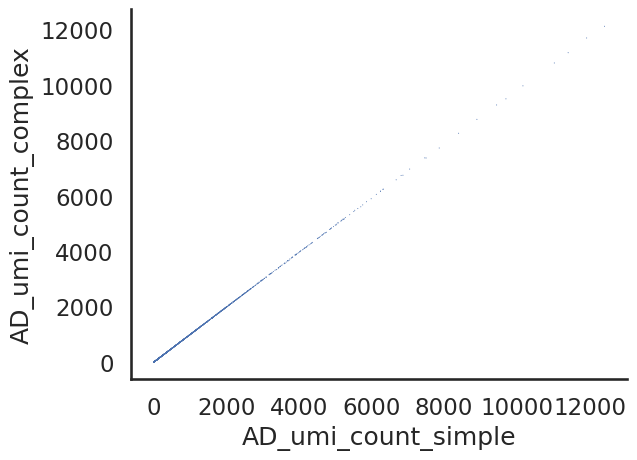

In [22]:
# Both simple and complex counts are roughly y = x which checks out!
AD_results_merged = pd.merge(all_complex_AD_results_df, all_simple_AD_results_df, on = ["ADBC_concat", "name", "number"],suffixes = ("_complex", "_simple"))
sns.scatterplot(data = AD_results_merged, x = "AD_umi_count_simple", y = "AD_umi_count_complex", s  = 0.5, edgecolor = 'none')
sns.despine()
plt.savefig(os.path.join(output_path, f"AD_umi_count_comparison.png"), bbox_inches='tight')

In [23]:
AD_results_merged["name"].value_counts()

name
a2_RNA_ADBC_S18    1133
a5_RNA_ADBC_S21    1061
a1_RNA_ADBC_S17     994
a4_RNA_ADBC_S20     946
a6_RNA_ADBC_S22     922
a7_RNA_ADBC_S23     791
a3_RNA_ADBC_S19     789
a8_RNA_ADBC_S24     708
Name: count, dtype: int64

# Next, RPTR analysis

In [24]:
RTBC_objects = [step1_RTBC]

In [25]:
complex_RPTR_results = []
simple_RPTR_results = []

r2_RNA_RTBC_S26
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r2_RNA_RTBC_S26
Reading 1 FASTQ/TXT file(s)...
Done in 1.66 seconds.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 2.15 seconds.

Extracting 1 barcodes...
GCCCC(.*)GCGG
Done in 0.42 seconds.

Extracting UMIs (12 bases)...
Done in 0.20 seconds.

Done in 0.63 seconds.

Mapping complete.
whitelisting
Done in 0.59 seconds.

Generating whitelist for RTBC (RC=True)…
Done in 36.46 seconds.

Whitelist generated for RTBC at /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r2_RNA_RTBC_S26/RTBC_whitelist.txt
Base prefix (stable across descriptors): umi_r2_RNA_RTBC_S26_RTBC_
Full prefix for this instance: umi_r2_RNA_RTBC_S26_RTBC_

Using the following step order:
1. initial
2. quality_designed

Filtering to quality and designed...
Done in 0.20 seconds.

Done.
Starting simple deduplication.
Finished simple deduplication.

Starting UMI Tools directional deduplication.
Generating FASTQ with UMIs in header and barcodes as sequence...
Writing FASTQ to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r2_RNA_RT

Writing FASTQ: 100%|██████████| 481535/481535 [00:00<00:00, 2195156.45it/s]


FASTQ complete: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r2_RNA_RTBC_S26/r2_RNA_RTBC_S26_umi_extracted.fastq
Done in 0.46 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: umi_r2_RNA_RTBC_S26_RTBC_unique_barcodes
Writing FASTA to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r2_RNA_RTBC_S26/r2_RNA_RTBC_S26_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r2_RNA_RTBC_S26/r2_RNA_RTBC_S26_barcodes_index


Building a SMALL index
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r2_RNA_RTBC_S26/r2_RNA_RTBC_S26_barcodes_index.3.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r2_RNA_RTBC_S26/r2_RNA_RTBC_S26_barcodes_index.3.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r2_RNA_RTBC_S26/r2_RNA_RTBC_S26_barcodes_index.4.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r2_RNA_RTBC_S26/r2_RNA_RTBC_S26_barcodes_index.4.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r2_RNA_RTBC_S26/r2_RNA_RTBC_S26_barcodes_index.1.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r2_RNA_RTBC_S26/r2_RNA_RTBC_S26_barcodes_index.1.bt2
Renaming /global/

Done in 0.80 seconds.

Aligning .FASTQ to reference .FA ...


481535 reads; of these:
  481535 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    481535 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r2_RNA_RTBC_S26/r2_RNA_RTBC_S26_umi_extracted.sorted.bam -S /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r2_RNA_RTBC_S26/r2_RNA_RTBC_S26_umi_deduplicated.bam
# job started at Wed Nov  5 15:51:14 2025 on n0072.savio3 -- f3aa4156-ff6f-400b-9e4a-95d18f43b0ce
# pid: 190530, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filte

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 2.26 seconds.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 2.14 seconds.

Extracting 1 barcodes...
GCCCC(.*)GCGG
Done in 0.40 seconds.

Extracting UMIs (12 bases)...
Done in 0.20 seconds.

Done in 0.56 seconds.

Mapping complete.
whitelisting
Done in 0.75 seconds.

Generating whitelist for RTBC (RC=True)…
Done in 30.41 seconds.

Whitelist generated for RTBC at /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r8_RNA_RTBC_S32/RTBC_whitelist.txt
Base prefix (stable across descriptors): umi_r8_RNA_RTBC_S32_RTBC_
Full prefix for this instance: umi_r8_RNA_RTBC_S32_RTBC_

Using the following step order:
1. initial
2. quality_designed

Filtering to quality and designed...
Done in 0.18 seconds.

Done.
Starting simple deduplication.
Finished simple deduplication.

Starting UMI Tools directional deduplication.
Generating FASTQ with UMIs in header and barcodes as sequence...
Writing FASTQ to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r8_RNA_RT

Writing FASTQ: 100%|██████████| 346495/346495 [00:00<00:00, 2103182.42it/s]


FASTQ complete: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r8_RNA_RTBC_S32/r8_RNA_RTBC_S32_umi_extracted.fastq
Done in 0.34 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: umi_r8_RNA_RTBC_S32_RTBC_unique_barcodes
Writing FASTA to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r8_RNA_RTBC_S32/r8_RNA_RTBC_S32_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r8_RNA_RTBC_S32/r8_RNA_RTBC_S32_barcodes_index


Building a SMALL index
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r8_RNA_RTBC_S32/r8_RNA_RTBC_S32_barcodes_index.3.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r8_RNA_RTBC_S32/r8_RNA_RTBC_S32_barcodes_index.3.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r8_RNA_RTBC_S32/r8_RNA_RTBC_S32_barcodes_index.4.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r8_RNA_RTBC_S32/r8_RNA_RTBC_S32_barcodes_index.4.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r8_RNA_RTBC_S32/r8_RNA_RTBC_S32_barcodes_index.1.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r8_RNA_RTBC_S32/r8_RNA_RTBC_S32_barcodes_index.1.bt2
Renaming /global/

Done in 0.95 seconds.

Aligning .FASTQ to reference .FA ...


346495 reads; of these:
  346495 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    346495 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r8_RNA_RTBC_S32/r8_RNA_RTBC_S32_umi_extracted.sorted.bam -S /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r8_RNA_RTBC_S32/r8_RNA_RTBC_S32_umi_deduplicated.bam
# job started at Wed Nov  5 15:52:30 2025 on n0072.savio3 -- 03f5e769-ffe1-4ff3-b7f4-894a7e2caf11
# pid: 190782, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filte

Writing FASTQ: 100%|██████████| 284482/284482 [00:00<00:00, 2091344.38it/s]

FASTQ complete: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r7_RNA_RTBC_S31/r7_RNA_RTBC_S31_umi_extracted.fastq
Done in 0.31 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: umi_r7_RNA_RTBC_S31_RTBC_unique_barcodes
Writing FASTA to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r7_RNA_RTBC_S31/r7_RNA_RTBC_S31_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r7_RNA_RTBC_S31/r7_RNA_RTBC_S31_barcodes_index



Building a SMALL index
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r7_RNA_RTBC_S31/r7_RNA_RTBC_S31_barcodes_index.3.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r7_RNA_RTBC_S31/r7_RNA_RTBC_S31_barcodes_index.3.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r7_RNA_RTBC_S31/r7_RNA_RTBC_S31_barcodes_index.4.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r7_RNA_RTBC_S31/r7_RNA_RTBC_S31_barcodes_index.4.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r7_RNA_RTBC_S31/r7_RNA_RTBC_S31_barcodes_index.1.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r7_RNA_RTBC_S31/r7_RNA_RTBC_S31_barcodes_index.1.bt2
Renaming /global

Done in 0.69 seconds.

Aligning .FASTQ to reference .FA ...


284482 reads; of these:
  284482 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    284482 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r7_RNA_RTBC_S31/r7_RNA_RTBC_S31_umi_extracted.sorted.bam -S /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r7_RNA_RTBC_S31/r7_RNA_RTBC_S31_umi_deduplicated.bam
# job started at Wed Nov  5 15:53:26 2025 on n0072.savio3 -- 6afcdcb0-7d51-4ffd-8918-ce223425f4bc
# pid: 191052, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filte

Writing FASTQ: 100%|██████████| 379569/379569 [00:00<00:00, 2168050.65it/s]


FASTQ complete: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r1_RNA_RTBC_S25/r1_RNA_RTBC_S25_umi_extracted.fastq
Done in 0.37 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: umi_r1_RNA_RTBC_S25_RTBC_unique_barcodes
Writing FASTA to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r1_RNA_RTBC_S25/r1_RNA_RTBC_S25_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r1_RNA_RTBC_S25/r1_RNA_RTBC_S25_barcodes_index


Building a SMALL index
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r1_RNA_RTBC_S25/r1_RNA_RTBC_S25_barcodes_index.3.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r1_RNA_RTBC_S25/r1_RNA_RTBC_S25_barcodes_index.3.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r1_RNA_RTBC_S25/r1_RNA_RTBC_S25_barcodes_index.4.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r1_RNA_RTBC_S25/r1_RNA_RTBC_S25_barcodes_index.4.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r1_RNA_RTBC_S25/r1_RNA_RTBC_S25_barcodes_index.1.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r1_RNA_RTBC_S25/r1_RNA_RTBC_S25_barcodes_index.1.bt2
Renaming /global/

Done in 0.75 seconds.

Aligning .FASTQ to reference .FA ...


379569 reads; of these:
  379569 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    379569 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r1_RNA_RTBC_S25/r1_RNA_RTBC_S25_umi_extracted.sorted.bam -S /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r1_RNA_RTBC_S25/r1_RNA_RTBC_S25_umi_deduplicated.bam
# job started at Wed Nov  5 15:54:21 2025 on n0072.savio3 -- 7ef14258-87e1-4836-a01a-4ffcc985433b
# pid: 191307, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filte

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 2.21 seconds.

Reverse complement of sequences...
Done in 1.91 seconds.

Extracting 1 barcodes...
GCCCC(.*)GCGG
Done in 0.39 seconds.

Extracting UMIs (12 bases)...
Done in 0.20 seconds.

Done in 0.51 seconds.

Mapping complete.
whitelisting
Done in 0.50 seconds.

Generating whitelist for RTBC (RC=True)…
Done in 32.74 seconds.

Whitelist generated for RTBC at /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r6_RNA_RTBC_S30/RTBC_whitelist.txt
Base prefix (stable across descriptors): umi_r6_RNA_RTBC_S30_RTBC_
Full prefix for this instance: umi_r6_RNA_RTBC_S30_RTBC_

Using the following step order:
1. initial
2. quality_designed

Filtering to quality and designed...
Done in 0.18 seconds.

Done.
Starting simple deduplication.
Finished simple deduplication.

Starting UMI Tools directional deduplication.
Generating FASTQ with UMIs in header and barcodes as sequence...
Writing FASTQ to /global/scratch/projects/fc_mvslab/OpenProjects/Sa

Writing FASTQ: 100%|██████████| 469596/469596 [00:00<00:00, 2196030.32it/s]


FASTQ complete: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r6_RNA_RTBC_S30/r6_RNA_RTBC_S30_umi_extracted.fastq
Done in 0.45 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: umi_r6_RNA_RTBC_S30_RTBC_unique_barcodes
Writing FASTA to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r6_RNA_RTBC_S30/r6_RNA_RTBC_S30_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r6_RNA_RTBC_S30/r6_RNA_RTBC_S30_barcodes_index


Building a SMALL index
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r6_RNA_RTBC_S30/r6_RNA_RTBC_S30_barcodes_index.3.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r6_RNA_RTBC_S30/r6_RNA_RTBC_S30_barcodes_index.3.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r6_RNA_RTBC_S30/r6_RNA_RTBC_S30_barcodes_index.4.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r6_RNA_RTBC_S30/r6_RNA_RTBC_S30_barcodes_index.4.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r6_RNA_RTBC_S30/r6_RNA_RTBC_S30_barcodes_index.1.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r6_RNA_RTBC_S30/r6_RNA_RTBC_S30_barcodes_index.1.bt2
Renaming /global/

Done in 1.02 seconds.

Aligning .FASTQ to reference .FA ...


469596 reads; of these:
  469596 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    469596 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r6_RNA_RTBC_S30/r6_RNA_RTBC_S30_umi_extracted.sorted.bam -S /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r6_RNA_RTBC_S30/r6_RNA_RTBC_S30_umi_deduplicated.bam
# job started at Wed Nov  5 15:55:30 2025 on n0072.savio3 -- cad78d26-c600-4f0a-beb6-0473467feb06
# pid: 191640, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filte

Writing FASTQ: 100%|██████████| 382474/382474 [00:00<00:00, 2155952.92it/s]


FASTQ complete: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r3_RNA_RTBC_S27/r3_RNA_RTBC_S27_umi_extracted.fastq
Done in 0.37 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: umi_r3_RNA_RTBC_S27_RTBC_unique_barcodes
Writing FASTA to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r3_RNA_RTBC_S27/r3_RNA_RTBC_S27_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r3_RNA_RTBC_S27/r3_RNA_RTBC_S27_barcodes_index


Building a SMALL index
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r3_RNA_RTBC_S27/r3_RNA_RTBC_S27_barcodes_index.3.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r3_RNA_RTBC_S27/r3_RNA_RTBC_S27_barcodes_index.3.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r3_RNA_RTBC_S27/r3_RNA_RTBC_S27_barcodes_index.4.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r3_RNA_RTBC_S27/r3_RNA_RTBC_S27_barcodes_index.4.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r3_RNA_RTBC_S27/r3_RNA_RTBC_S27_barcodes_index.1.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r3_RNA_RTBC_S27/r3_RNA_RTBC_S27_barcodes_index.1.bt2
Renaming /global/

Done in 1.15 seconds.

Aligning .FASTQ to reference .FA ...


382474 reads; of these:
  382474 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    382474 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r3_RNA_RTBC_S27/r3_RNA_RTBC_S27_umi_extracted.sorted.bam -S /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r3_RNA_RTBC_S27/r3_RNA_RTBC_S27_umi_deduplicated.bam
# job started at Wed Nov  5 15:56:41 2025 on n0072.savio3 -- b9147204-568d-46bc-94da-f104366ae68f
# pid: 191899, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filte

Writing FASTQ: 100%|██████████| 197554/197554 [00:00<00:00, 1915792.97it/s]

FASTQ complete: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r5_RNA_RTBC_S29/r5_RNA_RTBC_S29_umi_extracted.fastq
Done in 0.21 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: umi_r5_RNA_RTBC_S29_RTBC_unique_barcodes
Writing FASTA to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r5_RNA_RTBC_S29/r5_RNA_RTBC_S29_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r5_RNA_RTBC_S29/r5_RNA_RTBC_S29_barcodes_index



Building a SMALL index
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r5_RNA_RTBC_S29/r5_RNA_RTBC_S29_barcodes_index.3.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r5_RNA_RTBC_S29/r5_RNA_RTBC_S29_barcodes_index.3.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r5_RNA_RTBC_S29/r5_RNA_RTBC_S29_barcodes_index.4.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r5_RNA_RTBC_S29/r5_RNA_RTBC_S29_barcodes_index.4.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r5_RNA_RTBC_S29/r5_RNA_RTBC_S29_barcodes_index.1.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r5_RNA_RTBC_S29/r5_RNA_RTBC_S29_barcodes_index.1.bt2
Renaming /global

Done in 0.72 seconds.

Aligning .FASTQ to reference .FA ...


197554 reads; of these:
  197554 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    197554 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...
Indexing BAM ...
Deduplicating UMIs ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


# UMI-tools version: 1.1.6
# output generated by dedup -I /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r5_RNA_RTBC_S29/r5_RNA_RTBC_S29_umi_extracted.sorted.bam -S /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r5_RNA_RTBC_S29/r5_RNA_RTBC_S29_umi_deduplicated.bam
# job started at Wed Nov  5 15:57:33 2025 on n0072.savio3 -- cbc12a60-8aaa-4ebb-9e0a-5560c9ba29c7
# pid: 192150, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filter_umi                              : Non

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 3.97 seconds.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 3.48 seconds.

Extracting 1 barcodes...
GCCCC(.*)GCGG
Done in 0.43 seconds.

Extracting UMIs (12 bases)...
Done in 0.26 seconds.

Done in 1.03 seconds.

Mapping complete.
whitelisting
Done in 0.85 seconds.

Generating whitelist for RTBC (RC=True)…
Done in 50.10 seconds.

Whitelist generated for RTBC at /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r4_RNA_RTBC_S28/RTBC_whitelist.txt
Base prefix (stable across descriptors): umi_r4_RNA_RTBC_S28_RTBC_
Full prefix for this instance: umi_r4_RNA_RTBC_S28_RTBC_

Using the following step order:
1. initial
2. quality_designed

Filtering to quality and designed...
Done in 0.15 seconds.

Done.
Starting simple deduplication.
Finished simple deduplication.

Starting UMI Tools directional deduplication.
Generating FASTQ with UMIs in header and barcodes as sequence...
Writing FASTQ to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r4_RNA_RT

Writing FASTQ: 100%|██████████| 663677/663677 [00:00<00:00, 2208078.78it/s]


FASTQ complete: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r4_RNA_RTBC_S28/r4_RNA_RTBC_S28_umi_extracted.fastq
Done in 0.63 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: umi_r4_RNA_RTBC_S28_RTBC_unique_barcodes
Writing FASTA to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r4_RNA_RTBC_S28/r4_RNA_RTBC_S28_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r4_RNA_RTBC_S28/r4_RNA_RTBC_S28_barcodes_index


Building a SMALL index
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r4_RNA_RTBC_S28/r4_RNA_RTBC_S28_barcodes_index.3.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r4_RNA_RTBC_S28/r4_RNA_RTBC_S28_barcodes_index.3.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r4_RNA_RTBC_S28/r4_RNA_RTBC_S28_barcodes_index.4.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r4_RNA_RTBC_S28/r4_RNA_RTBC_S28_barcodes_index.4.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r4_RNA_RTBC_S28/r4_RNA_RTBC_S28_barcodes_index.1.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r4_RNA_RTBC_S28/r4_RNA_RTBC_S28_barcodes_index.1.bt2
Renaming /global/

Done in 1.13 seconds.

Aligning .FASTQ to reference .FA ...


663677 reads; of these:
  663677 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    663677 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r4_RNA_RTBC_S28/r4_RNA_RTBC_S28_umi_extracted.sorted.bam -S /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist/umi_r4_RNA_RTBC_S28/r4_RNA_RTBC_S28_umi_deduplicated.bam
# job started at Wed Nov  5 15:58:53 2025 on n0072.savio3 -- c0fdf88a-20f1-4967-a397-da76dcb29746
# pid: 192411, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filte

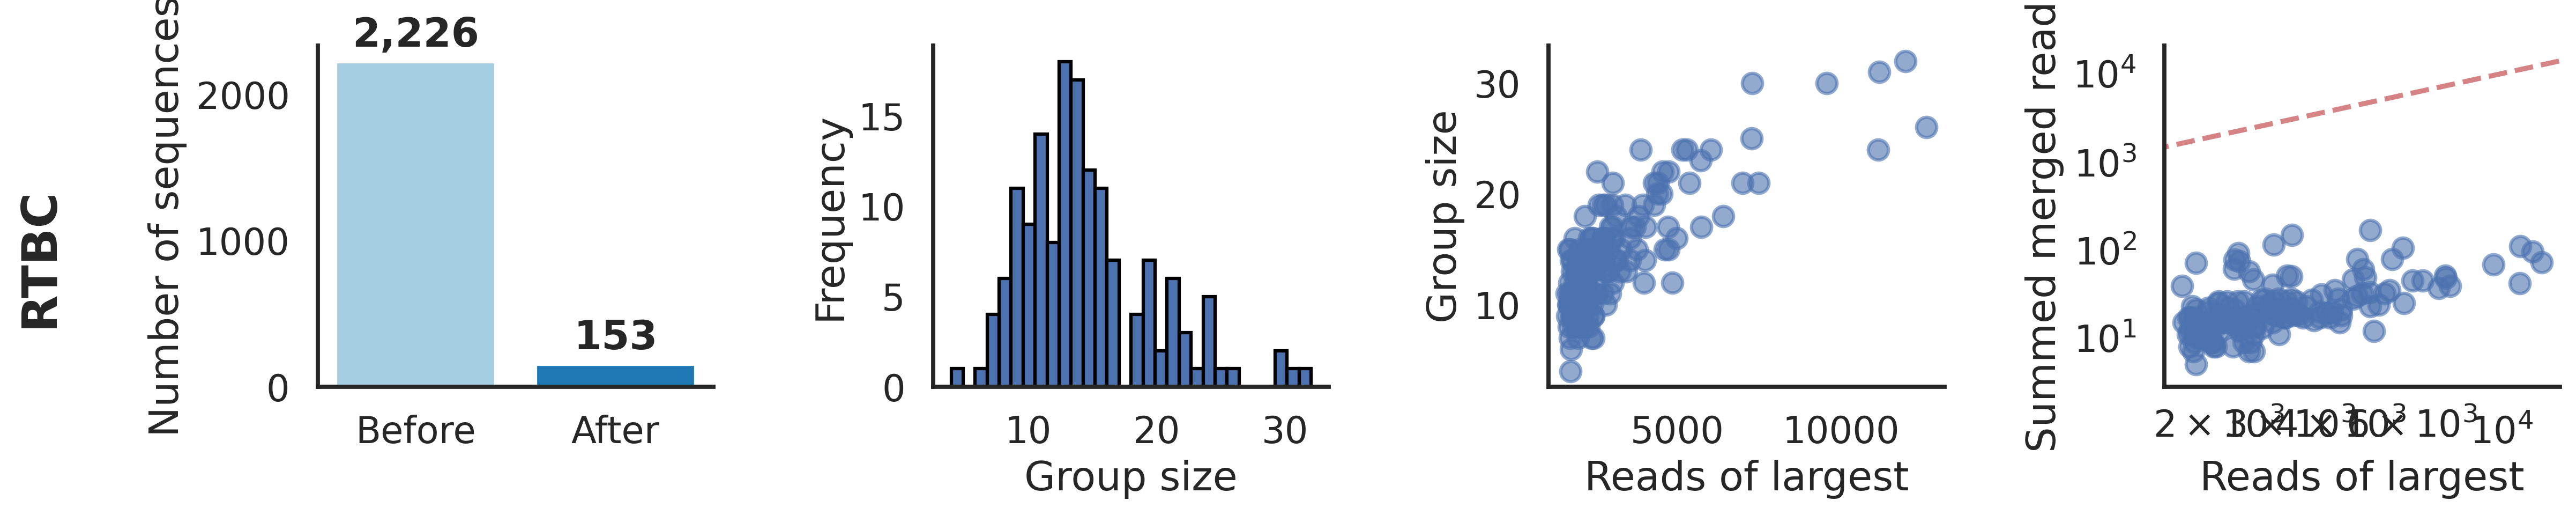

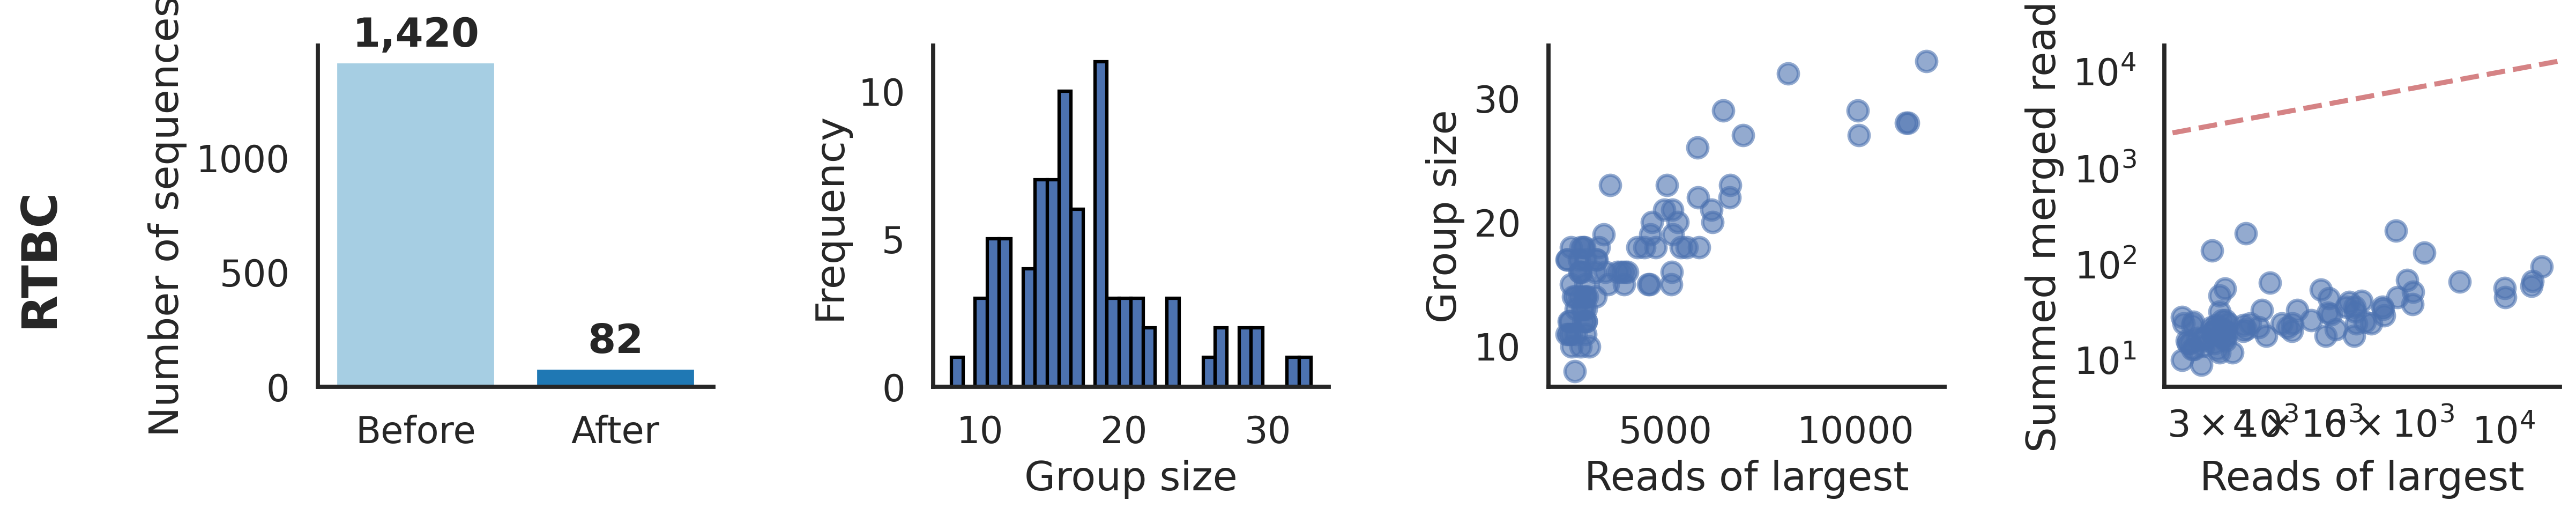

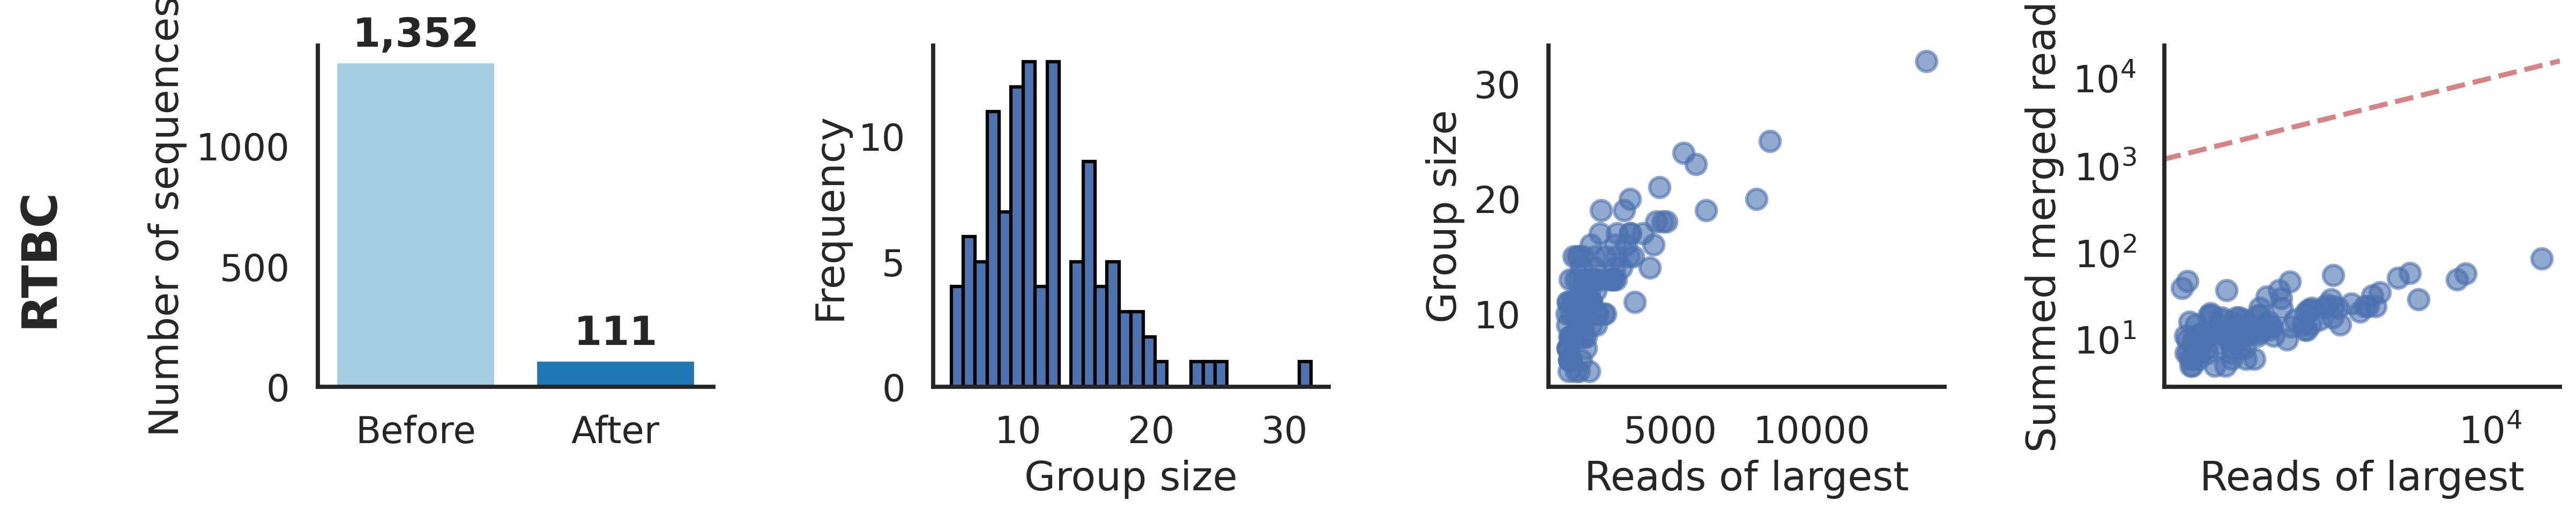

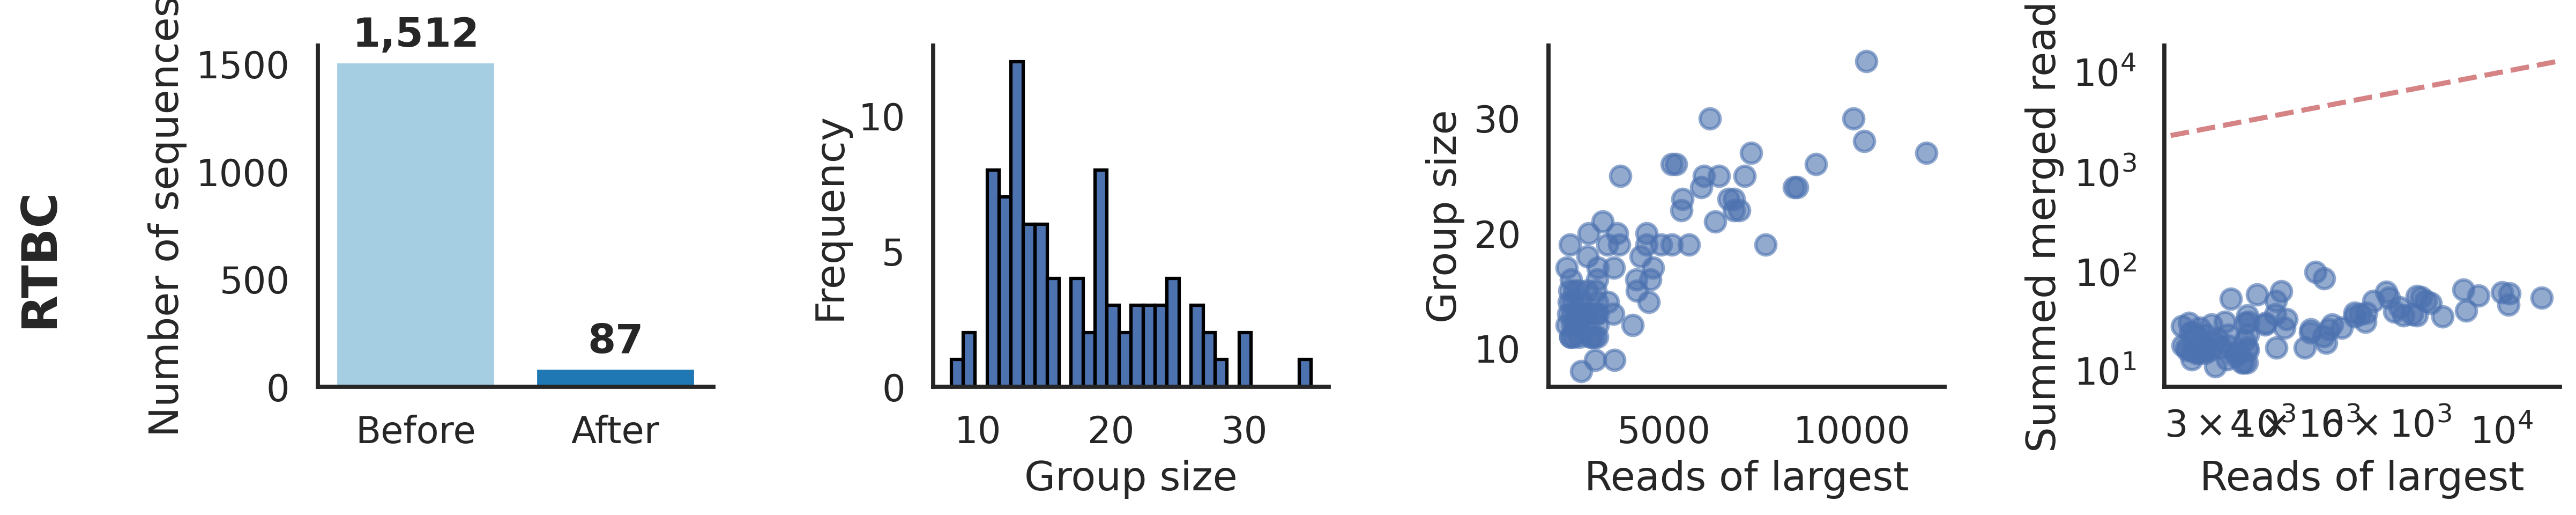

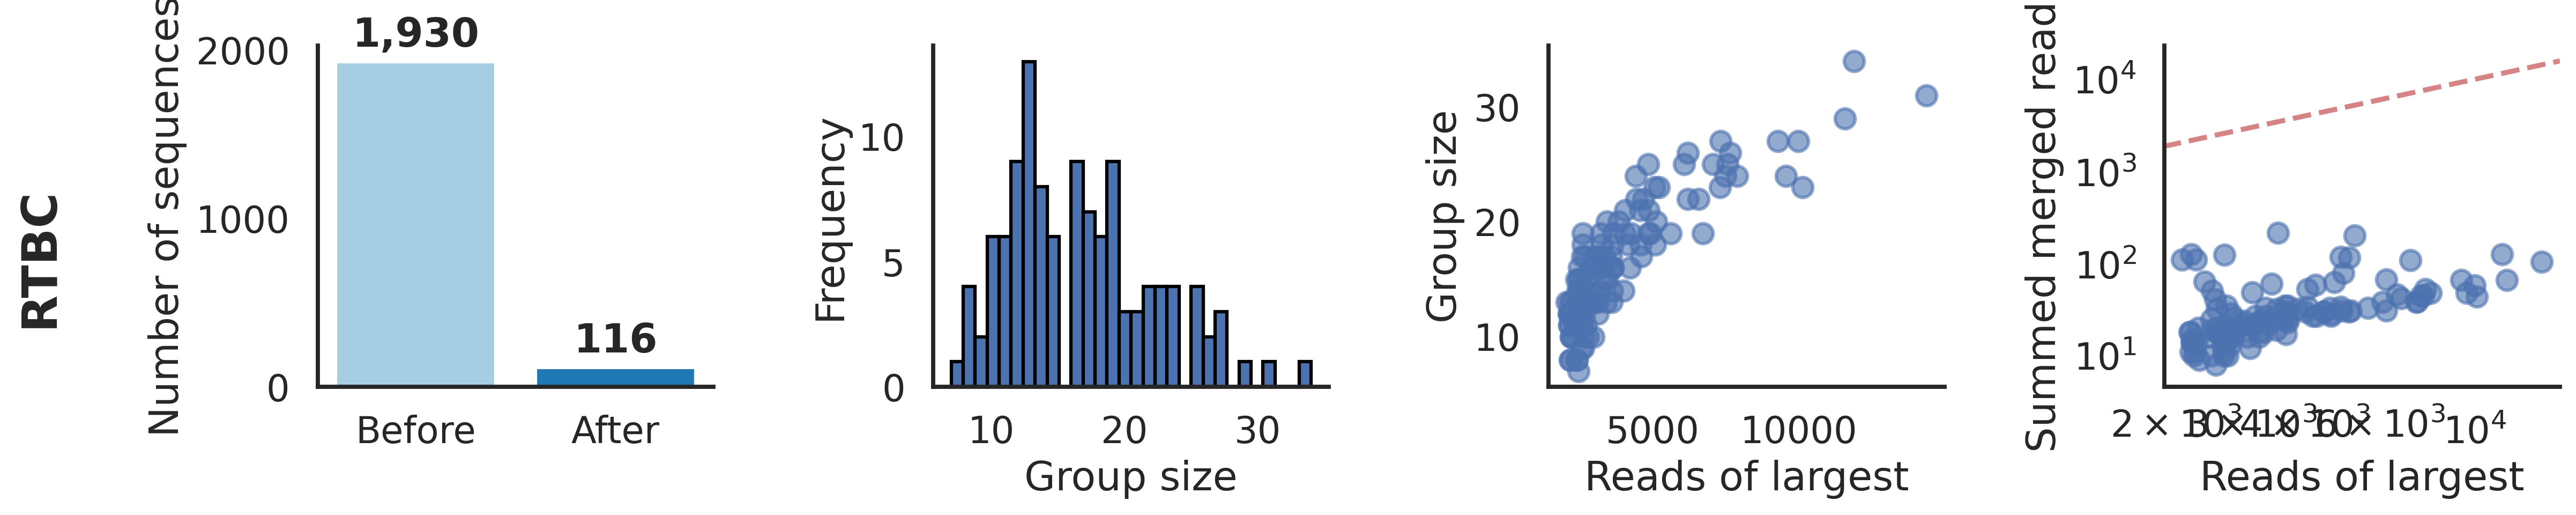

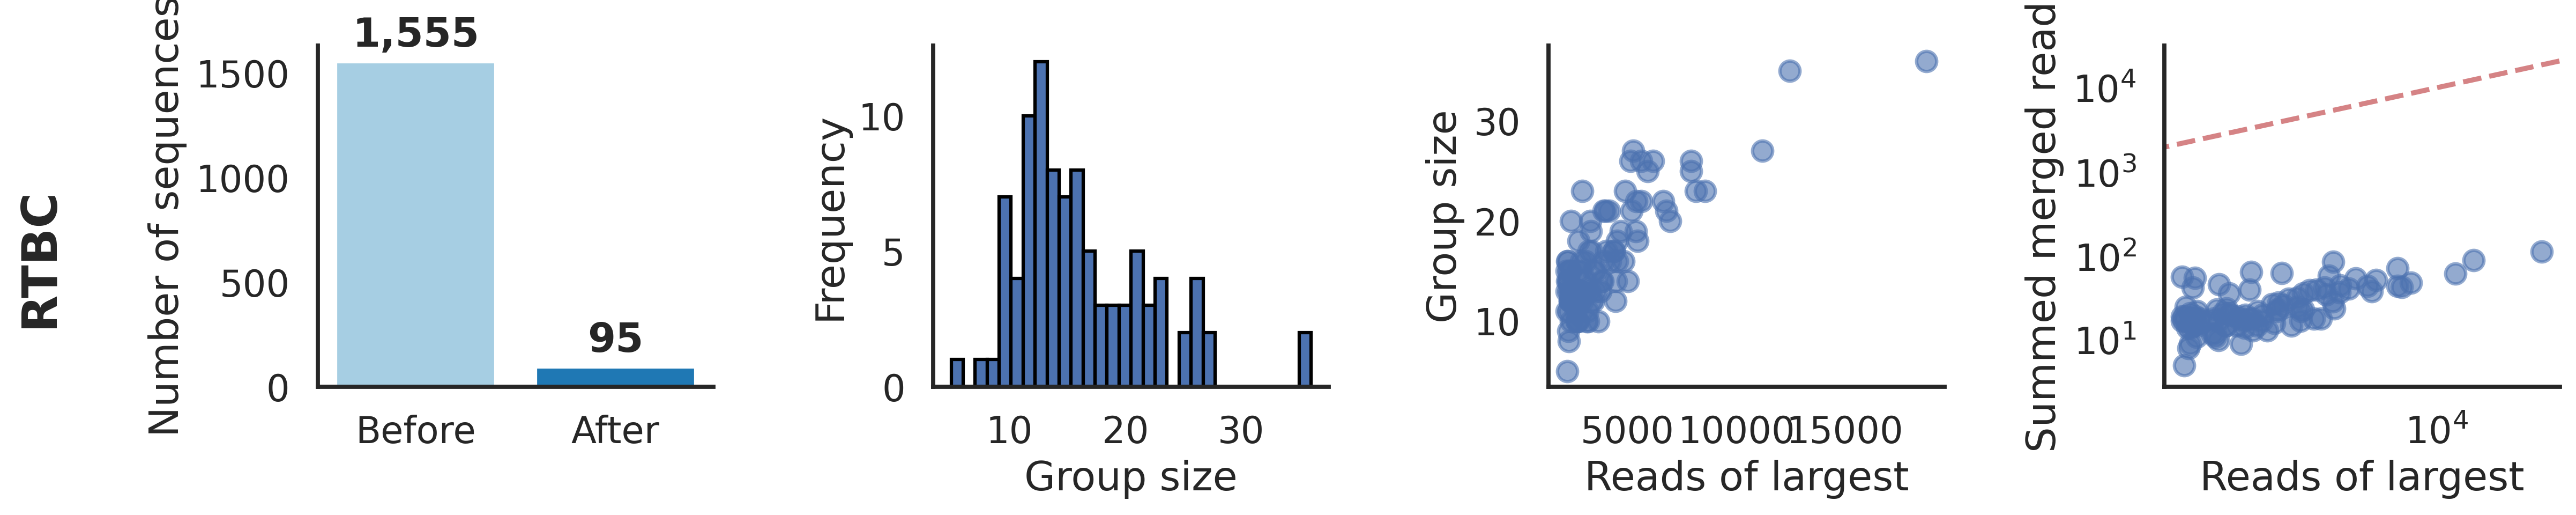

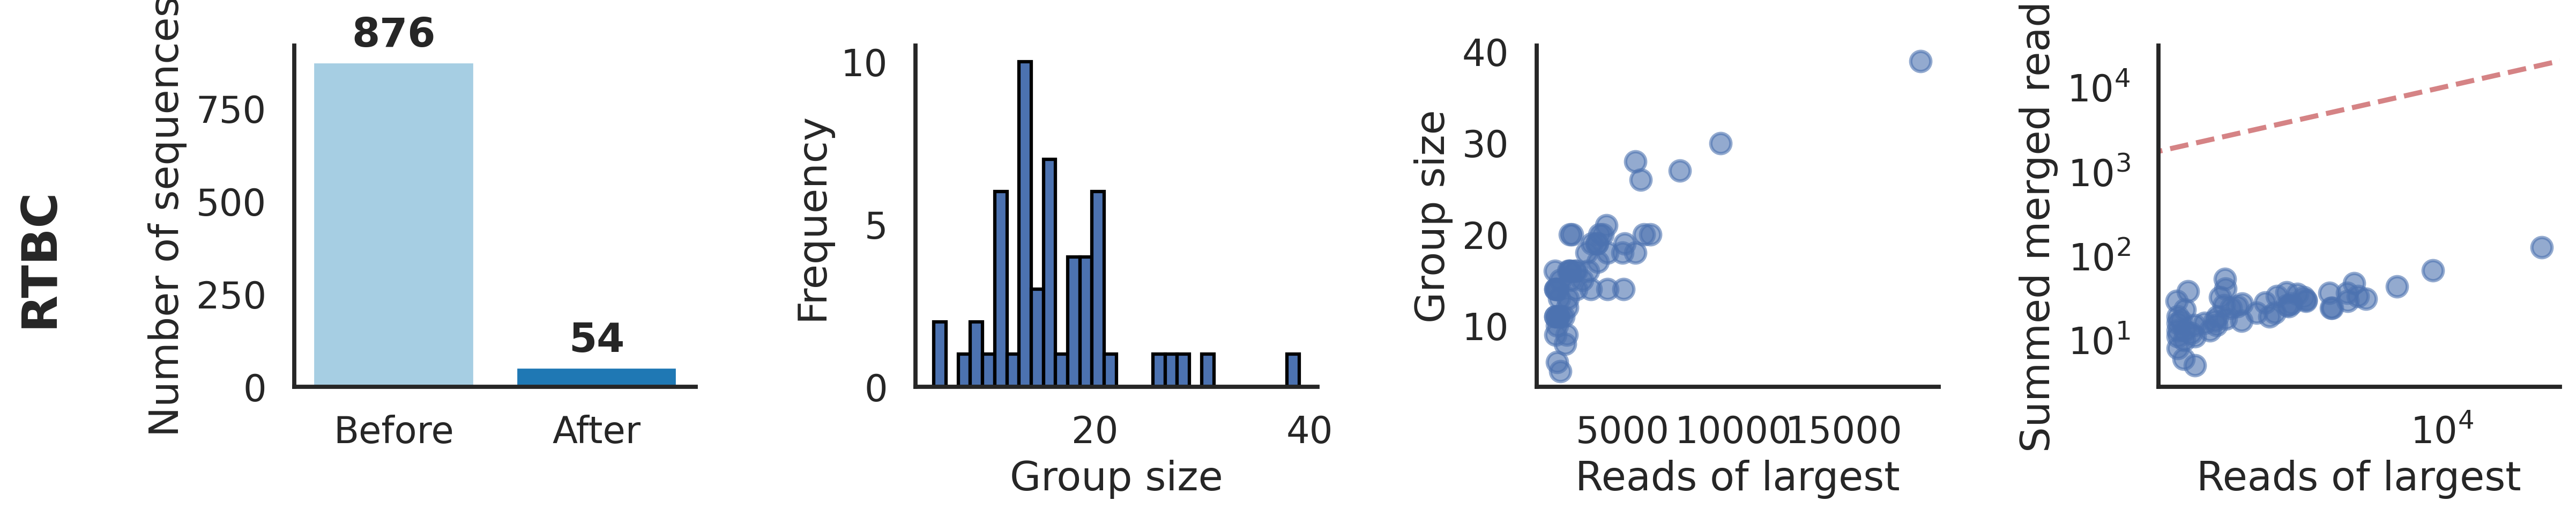

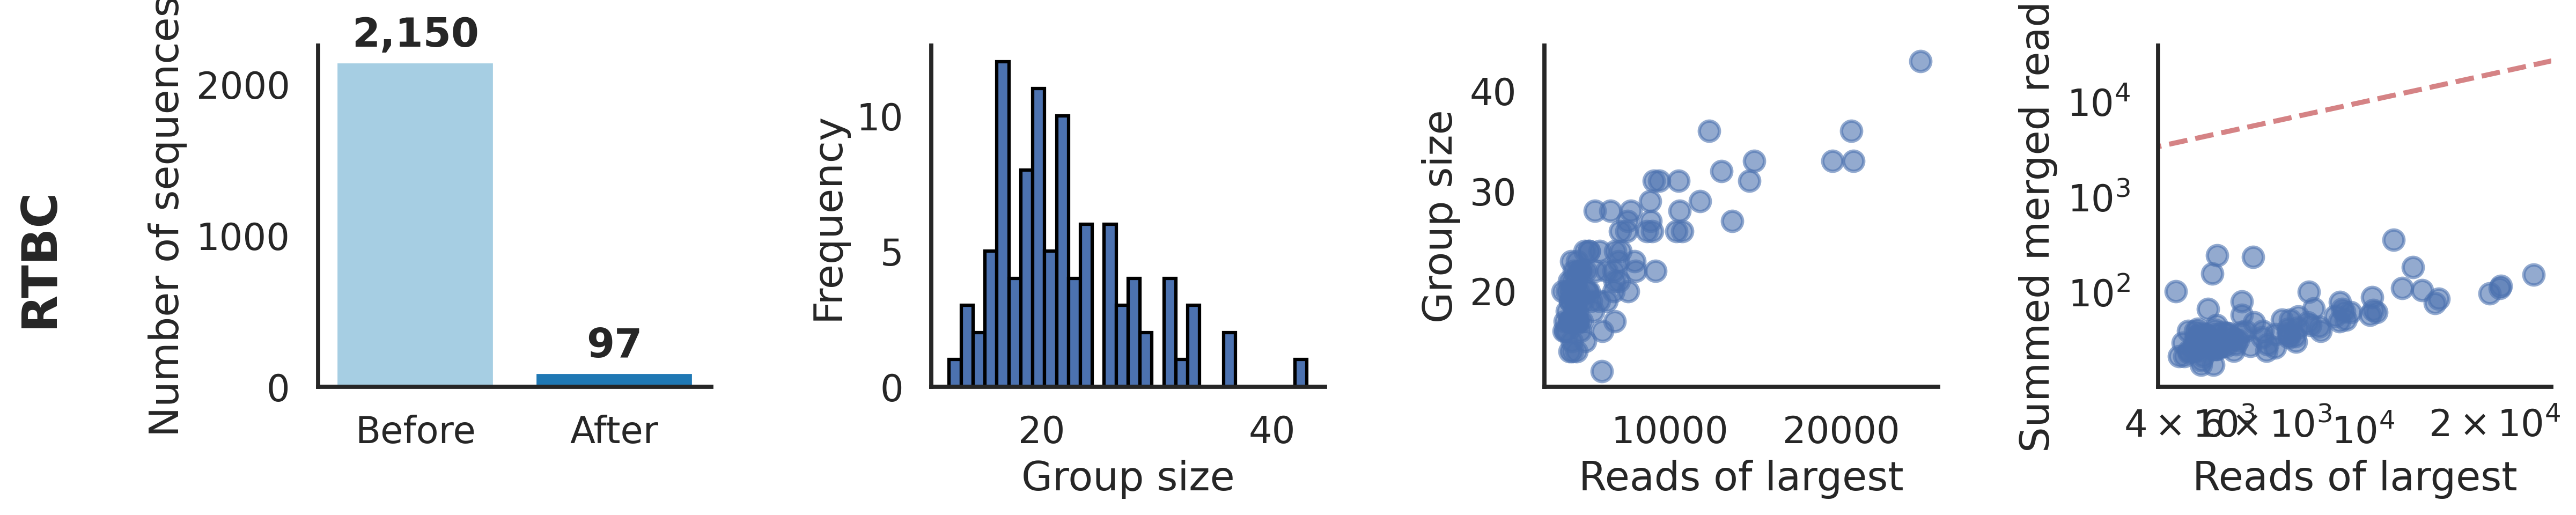

In [145]:
for file_path in RT_seq_files:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0]
    print(name_only) 

    # Get the file naeme to use for output
    umi_path = os.path.join(output_path, f"umi_{name_only}")
    print(umi_path)

    # Extract UMIs and barcodes from reads
    umi_mapper = initial_map.InitialMapper(db_path = db_path,
                                       step_name = f"umi_{name_only}", 
                                       seq_file = file_path,
                                       design_file_path = None,
                                       bc_objects = [step1_RTBC],
                                       reverse_complement = True,
                                       umi_length = 12)
    umi_mapper.create_map()
    
    print("whitelisting")
    umi_mapper.apply_whitelist(umi_path)

    # Only keep barcodes of correct length
    refiner = map_refiner.MapRefiner(db_path = db_path,
                                        bc_objects=RTBC_objects,
                                        column_pairs = [],
                                        reads_threshold = 1,
                                        map_order = ['quality_designed'],
                                        step_name=f"umi_{name_only}", 
                                        descriptor = "")
    refiner.refine_map_from_db()

    # Run both deduplications
    deduplicator = umi_deduplicate.UMIDeduplicator(db_path = db_path,
                                                        bc_objects = RTBC_objects,
                                                        step_name = f"umi_{name_only}", 
                                                        descriptor = "",
                                                        step1_map_name = None,
                                                        fastq_path = file_path,
                                                        umi_length = 12,
                                                        output_path = umi_path)

    deduplicator.run_both_deduplications()

    # Collect results
    one_file_complex_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_directional_umi_counts.tsv"), sep = "\t")
    one_file_complex_results["name"] = name_only
    complex_RPTR_results.append(one_file_complex_results)

    one_file_simple_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_simple_umi_counts.tsv"), sep = "\t")
    one_file_simple_results["name"] = name_only
    simple_RPTR_results.append(one_file_simple_results)

In [27]:
all_complex_RPTR_results_df = pd.concat(complex_RPTR_results)
all_complex_RPTR_results_df = all_complex_RPTR_results_df.rename(columns = {"count" : "RTBC_umi_count", "gene" : "RTBC"})
all_complex_RPTR_results_df["number"] = all_complex_RPTR_results_df["name"].str[1]
all_complex_RPTR_results_df

RTBC  RTBC_umi_count             name number
0   TGGTTATTTTTTGTTT            1684  r2_RNA_RTBC_S26      2
1   GTCGGATATTCATCCA            2192  r2_RNA_RTBC_S26      2
2   CAGAATTAAACCTGAA            1551  r2_RNA_RTBC_S26      2
3   TTAATCGAAAGCGGCT            1603  r2_RNA_RTBC_S26      2
4   AAGCATTGCATGCAGT            1455  r2_RNA_RTBC_S26      2
..               ...             ...              ...    ...
92  AAAGAATCGTTCTAAA            2793  r4_RNA_RTBC_S28      4
93  GATAATGTACAGACCA            2752  r4_RNA_RTBC_S28      4
94  CTGAGTCAATCACTGA            2993  r4_RNA_RTBC_S28      4
95  GACTCGCTGTATGAGG            3519  r4_RNA_RTBC_S28      4
96  CGAGTTTTTTGACAAA            3360  r4_RNA_RTBC_S28      4

[795 rows x 4 columns]

In [28]:
all_complex_RPTR_results_df.to_csv(os.path.join(output_path, f"all_complex_RPTR_results.csv"))

In [29]:
all_simple_RPTR_results_df = pd.concat(simple_RPTR_results)
all_simple_RPTR_results_df = all_simple_RPTR_results_df.rename(columns = {"count" : "RTBC_umi_count"})
all_simple_RPTR_results_df["number"] = all_simple_RPTR_results_df["name"].str[1]
all_simple_RPTR_results_df

RTBC  RTBC_umi_count             name number
0   TTGACTATAATACATA            9774  r2_RNA_RTBC_S26      2
1   AGATATGCTTCTCGAT            9142  r2_RNA_RTBC_S26      2
2   ATGACAATGAACATAT            8581  r2_RNA_RTBC_S26      2
3   CGAGCCTATAGCATAA            8517  r2_RNA_RTBC_S26      2
4   ATTTTTGAATTTTTAT            7439  r2_RNA_RTBC_S26      2
..               ...             ...              ...    ...
92  AACATATCCAACGCTG            2588  r4_RNA_RTBC_S28      4
93  TGTTTGTGATATATGA            2557  r4_RNA_RTBC_S28      4
94  TATTTACCGTAGCAAT            2542  r4_RNA_RTBC_S28      4
95  TGCGGGCGAGATTTTG            2522  r4_RNA_RTBC_S28      4
96  GATATGCATACCATAT            2470  r4_RNA_RTBC_S28      4

[795 rows x 4 columns]

In [30]:
all_simple_RPTR_results_df.to_csv(os.path.join(output_path, f"all_simple_RPTR_results.csv"))

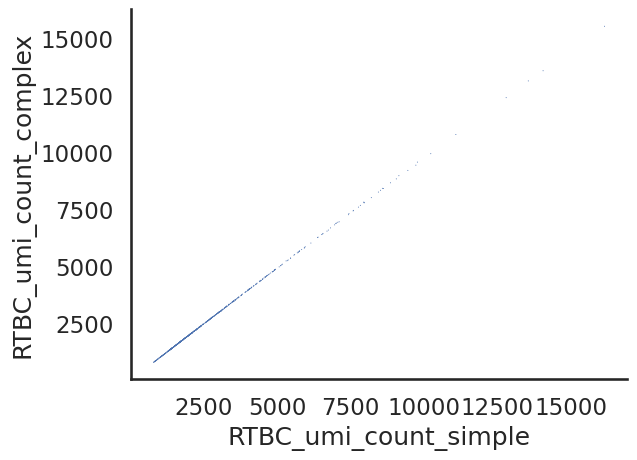

In [31]:
# Both simple and complex counts are roughly y = x which checks out!
RPTR_results_merged = pd.merge(all_complex_RPTR_results_df, all_simple_RPTR_results_df, on = ["RTBC", "name", "number"],suffixes = ("_complex", "_simple"))
sns.scatterplot(data = RPTR_results_merged, x = "RTBC_umi_count_simple", y = "RTBC_umi_count_complex", s  = 0.5, edgecolor = 'none')
sns.despine()
plt.savefig(os.path.join(output_path, f"RPTR_umi_count_comparison.png"), bbox_inches='tight')


In [32]:
RPTR_results_merged["name"].value_counts()

name
r2_RNA_RTBC_S26    153
r6_RNA_RTBC_S30    116
r7_RNA_RTBC_S31    111
r4_RNA_RTBC_S28     97
r3_RNA_RTBC_S27     95
r1_RNA_RTBC_S25     87
r8_RNA_RTBC_S32     82
r5_RNA_RTBC_S29     54
Name: count, dtype: int64

# Now, merge with step1 map

In [88]:
step1_map = pd.read_csv(step1_csv, index_col = 0)
step1_map

ADBC2    HawkBCs              RTBC  \
0     CCATAA  CACCGATTG  CAGCGTTTAACAAGCG   
1     GTCAGC  CCATTAACG  TGTAAAATGGGGCTGG   
2     GTACAA  CCATCGGTT  TTGCAGAATAGCTGCA   
3     TGGGAC  ACCGGATGT  CACAAAACGTGGCGCC   
4     CTAATA  ATCAGGACC  CAGGAAATCCCTCTAT   
...      ...        ...               ...   
3731  CTATAC  AACAGCCGA  ATCTACAATTTCTCTT   
3732  AGGCCA  AACACAAGC  ACCAACTCCTTAGGTA   
3733  GAACTG  ACGTCGAGA  TATTATATAGTTTGGA   
3734  GCTATT  ACTTGTTCC  CTTAGGCATGGCGATA   
3735  TGGGAC  ACGTCGAGA  CACAAAACGTGGCGCC   

                                                     AD  count  ADBC2_qual  \
0     GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...  11172        True   
1     GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...   9261        True   
2     GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...   7239        True   
3     GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   7042        True   
4     GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...   6387        True   
...                                                 ...    ...         ...   
3731  CCTCCCATGCCCAGCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
3732  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
3733  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
3734  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGGCGCTCCCAGCGCCT...      6        True   
3735  GCCCAGGACCTGGCCTTCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   

      HawkBCs_qual  RTBC_qual  AD_qual  Designed  
0             True       True     True         1  
1             True       True     True         1  
2             True       True     True         1  
3             True       True     True         1  
4             True       True     True         1  
...            ...        ...      ...       ...  
3731          True       True     True         1  
3732          True       True     True         1  
3733          True       True     True         1  
3734          True       True     True         1  
3735          True       True     True         1  

[3736 rows x 10 columns]

In [89]:
# Concatenated ADBC2 and HawkBC
step1_map["ADBC_concat"] = step1_map["ADBC2"] + step1_map["HawkBCs"] 
step1_map

ADBC2    HawkBCs              RTBC  \
0     CCATAA  CACCGATTG  CAGCGTTTAACAAGCG   
1     GTCAGC  CCATTAACG  TGTAAAATGGGGCTGG   
2     GTACAA  CCATCGGTT  TTGCAGAATAGCTGCA   
3     TGGGAC  ACCGGATGT  CACAAAACGTGGCGCC   
4     CTAATA  ATCAGGACC  CAGGAAATCCCTCTAT   
...      ...        ...               ...   
3731  CTATAC  AACAGCCGA  ATCTACAATTTCTCTT   
3732  AGGCCA  AACACAAGC  ACCAACTCCTTAGGTA   
3733  GAACTG  ACGTCGAGA  TATTATATAGTTTGGA   
3734  GCTATT  ACTTGTTCC  CTTAGGCATGGCGATA   
3735  TGGGAC  ACGTCGAGA  CACAAAACGTGGCGCC   

                                                     AD  count  ADBC2_qual  \
0     GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...  11172        True   
1     GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...   9261        True   
2     GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...   7239        True   
3     GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   7042        True   
4     GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...   6387        True   
...                                                 ...    ...         ...   
3731  CCTCCCATGCCCAGCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
3732  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
3733  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
3734  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGGCGCTCCCAGCGCCT...      6        True   
3735  GCCCAGGACCTGGCCTTCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   

      HawkBCs_qual  RTBC_qual  AD_qual  Designed      ADBC_concat  
0             True       True     True         1  CCATAACACCGATTG  
1             True       True     True         1  GTCAGCCCATTAACG  
2             True       True     True         1  GTACAACCATCGGTT  
3             True       True     True         1  TGGGACACCGGATGT  
4             True       True     True         1  CTAATAATCAGGACC  
...            ...        ...      ...       ...              ...  
3731          True       True     True         1  CTATACAACAGCCGA  
3732          True       True     True         1  AGGCCAAACACAAGC  
3733          True       True     True         1  GAACTGACGTCGAGA  
3734          True       True     True         1  GCTATTACTTGTTCC  
3735          True       True     True         1  TGGGACACGTCGAGA  

[3736 rows x 11 columns]

In [90]:
# Add simple AD UMI counts to step1 map
step1_map_with_AD = pd.merge(step1_map, AD_results_merged).drop_duplicates()
step1_map_with_AD

ADBC2    HawkBCs              RTBC  \
0     CCATAA  CACCGATTG  CAGCGTTTAACAAGCG   
1     CCATAA  CACCGATTG  CAGCGTTTAACAAGCG   
2     CCATAA  CACCGATTG  CAGCGTTTAACAAGCG   
3     CCATAA  CACCGATTG  CAGCGTTTAACAAGCG   
4     CCATAA  CACCGATTG  CAGCGTTTAACAAGCG   
...      ...        ...               ...   
2607  TTAGGC  CAACAGTGC  CGAGCCTATAGCATAA   
2608  TTAGGC  CAACAGTGC  CGAGCCTATAGCATAA   
2609  TTAGGC  CAACAGTGC  CGAGCCTATAGCATAA   
2610  TTAGGC  CAACAGTGC  CGAGCCTATAGCATAA   
2611  TTAGGC  CAACAGTGC  CGAGCCTATAGCATAA   

                                                     AD  count  ADBC2_qual  \
0     GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...  11172        True   
1     GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...  11172        True   
2     GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...  11172        True   
3     GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...  11172        True   
4     GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...  11172        True   
...                                                 ...    ...         ...   
2607  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
2608  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
2609  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
2610  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
2611  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   

      HawkBCs_qual  RTBC_qual  AD_qual  Designed      ADBC_concat  \
0             True       True     True         1  CCATAACACCGATTG   
1             True       True     True         1  CCATAACACCGATTG   
2             True       True     True         1  CCATAACACCGATTG   
3             True       True     True         1  CCATAACACCGATTG   
4             True       True     True         1  CCATAACACCGATTG   
...            ...        ...      ...       ...              ...   
2607          True       True     True         1  TTAGGCCAACAGTGC   
2608          True       True     True         1  TTAGGCCAACAGTGC   
2609          True       True     True         1  TTAGGCCAACAGTGC   
2610          True       True     True         1  TTAGGCCAACAGTGC   
2611          True       True     True         1  TTAGGCCAACAGTGC   

      AD_umi_count_complex             name number  AD_umi_count_simple  
0                     8766  a2_RNA_ADBC_S18      2                 8900  
1                     9285  a7_RNA_ADBC_S23      7                 9442  
2                     7732  a1_RNA_ADBC_S17      1                 7863  
3                    12124  a3_RNA_ADBC_S19      3                12412  
4                     6742  a6_RNA_ADBC_S22      6                 6814  
...                    ...              ...    ...                  ...  
2607                  4833  a3_RNA_ADBC_S19      3                 4885  
2608                  4811  a6_RNA_ADBC_S22      6                 4872  
2609                  4113  a4_RNA_ADBC_S20      4                 4154  
2610                  5163  a8_RNA_ADBC_S24      8                 5222  
2611                  5548  a5_RNA_ADBC_S21      5                 5622  

[2612 rows x 15 columns]

In [99]:
# Add RPTR UMI counts to step1 map
step1_map_with_RPTR = pd.merge(step1_map, RPTR_results_merged).drop_duplicates()
step1_map_with_RPTR

ADBC2    HawkBCs              RTBC  \
0     CCATAA  CACCGATTG  CAGCGTTTAACAAGCG   
1     CCATAA  CACCGATTG  CAGCGTTTAACAAGCG   
2     CCATAA  CACCGATTG  CAGCGTTTAACAAGCG   
3     CCATAA  CACCGATTG  CAGCGTTTAACAAGCG   
4     CCATAA  CACCGATTG  CAGCGTTTAACAAGCG   
...      ...        ...               ...   
1911  TTAGGC  CAACAGTGC  CGAGCCTATAGCATAA   
1912  TTAGGC  CAACAGTGC  CGAGCCTATAGCATAA   
1913  TTAGGC  CAACAGTGC  CGAGCCTATAGCATAA   
1914  TTAGGC  CAACAGTGC  CGAGCCTATAGCATAA   
1915  TGGGAC  ACGTCGAGA  CACAAAACGTGGCGCC   

                                                     AD  count  ADBC2_qual  \
0     GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...  11172        True   
1     GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...  11172        True   
2     GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...  11172        True   
3     GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...  11172        True   
4     GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...  11172        True   
...                                                 ...    ...         ...   
1911  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
1912  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
1913  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
1914  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
1915  GCCCAGGACCTGGCCTTCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   

      HawkBCs_qual  RTBC_qual  AD_qual  Designed      ADBC_concat  \
0             True       True     True         1  CCATAACACCGATTG   
1             True       True     True         1  CCATAACACCGATTG   
2             True       True     True         1  CCATAACACCGATTG   
3             True       True     True         1  CCATAACACCGATTG   
4             True       True     True         1  CCATAACACCGATTG   
...            ...        ...      ...       ...              ...   
1911          True       True     True         1  TTAGGCCAACAGTGC   
1912          True       True     True         1  TTAGGCCAACAGTGC   
1913          True       True     True         1  TTAGGCCAACAGTGC   
1914          True       True     True         1  TTAGGCCAACAGTGC   
1915          True       True     True         1  TGGGACACGTCGAGA   

      RTBC_umi_count_complex             name number  RTBC_umi_count_simple  
0                       5234  r2_RNA_RTBC_S26      2                   5296  
1                       7795  r8_RNA_RTBC_S32      8                   7951  
2                       8018  r7_RNA_RTBC_S31      7                   8203  
3                       5349  r1_RNA_RTBC_S25      1                   5450  
4                       4758  r6_RNA_RTBC_S30      6                   4832  
...                      ...              ...    ...                    ...  
1911                    6393  r6_RNA_RTBC_S30      6                   6510  
1912                    6417  r3_RNA_RTBC_S27      3                   6542  
1913                    3023  r5_RNA_RTBC_S29      5                   3059  
1914                   12416  r4_RNA_RTBC_S28      4                  12801  
1915                    1495  r2_RNA_RTBC_S26      2                   1503  

[1916 rows x 15 columns]

In [92]:
merge_cols = set(step1_map_with_AD.columns) & set(step1_map_with_RPTR.columns)
merge_cols = [col for col in list(merge_cols) if col != "name"]
merge_cols

['HawkBCs',
 'ADBC_concat',
 'HawkBCs_qual',
 'ADBC2_qual',
 'ADBC2',
 'AD',
 'RTBC_qual',
 'AD_qual',
 'number',
 'count',
 'Designed',
 'RTBC']

In [100]:
step1_map_with_AD_RPTR = pd.merge(step1_map_with_AD, step1_map_with_RPTR, on = merge_cols, how = 'outer', suffixes = ("_AD", "_RPTR"))
step1_map_with_AD_RPTR = step1_map_with_AD_RPTR.fillna(0)
step1_map_with_AD_RPTR

ADBC2    HawkBCs              RTBC  \
0     ACACCT  AACAGCCGA  TATAGCACGACGTTCG   
1     TGATGT  AACAGCCGA  TGTCATAGATATGATA   
2     TGATGT  AACAGCCGA  TGTCATAGATATGATA   
3     TGGGAC  AACCTACGC  CACAAAACGTGGCGCC   
4     AATGCC  AACCTCTTC  GGTTATGTCGTCTTGG   
...      ...        ...               ...   
3488  GAAATT  CCGATCTAT  TAATTTGACTAAGAAC   
3489  CCGACA  CCGCAGTTA  TGTATAAGTCTATGTT   
3490  CCGACA  CCGCAGTTA  TGTATAAGTCTATGTT   
3491  CCGACA  CCGGAGAAT  TGTATAAGTCTATGTT   
3492  TGTTTA  CCGGAGAAT  GGGCATAGGCTTGACA   

                                                     AD  count  ADBC2_qual  \
0     CCTCCCATGCCCAGCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      7        True   
1     CCTCCCATGCCCAGCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   1249        True   
2     GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...     66        True   
3     GCCCAGGACCTGAGCAGCCTGACCTTCCAGGCCGGCATTCCCTTCA...      8        True   
4     GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...   1237        True   
...                                                 ...    ...         ...   
3488  ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGA...   3478        True   
3489  ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGA...   3928        True   
3490  ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...      9        True   
3491  ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...      7        True   
3492  ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...      6        True   

      HawkBCs_qual  RTBC_qual  AD_qual  Designed      ADBC_concat  \
0             True       True     True         1  ACACCTAACAGCCGA   
1             True       True     True         1  TGATGTAACAGCCGA   
2             True       True     True         1  TGATGTAACAGCCGA   
3             True       True     True         1  TGGGACAACCTACGC   
4             True       True     True         1  AATGCCAACCTCTTC   
...            ...        ...      ...       ...              ...   
3488          True       True     True         1  GAAATTCCGATCTAT   
3489          True       True     True         1  CCGACACCGCAGTTA   
3490          True       True     True         1  CCGACACCGCAGTTA   
3491          True       True     True         1  CCGACACCGGAGAAT   
3492          True       True     True         1  TGTTTACCGGAGAAT   

      AD_umi_count_complex          name_AD number  AD_umi_count_simple  \
0                      0.0                0      7                  0.0   
1                      0.0                0      2                  0.0   
2                      0.0                0      2                  0.0   
3                      0.0                0      2                  0.0   
4                     44.0  a4_RNA_ADBC_S20      4                 44.0   
...                    ...              ...    ...                  ...   
3488                   0.0                0      8                  0.0   
3489                   0.0                0      2                  0.0   
3490                   0.0                0      2                  0.0   
3491                   0.0                0      2                  0.0   
3492                   0.0                0      7                  0.0   

      RTBC_umi_count_complex        name_RPTR  RTBC_umi_count_simple  
0                      774.0  r7_RNA_RTBC_S31                  777.0  
1                     1318.0  r2_RNA_RTBC_S26                 1322.0  
2                     1318.0  r2_RNA_RTBC_S26                 1322.0  
3                     1495.0  r2_RNA_RTBC_S26                 1503.0  
4                        0.0                0                    0.0  
...                      ...              ...                    ...  
3488                  1960.0  r8_RNA_RTBC_S32                 1983.0  
3489                  1485.0  r2_RNA_RTBC_S26                 1490.0  
3490                  1485.0  r2_RNA_RTBC_S26                 1490.0  
3491                  1485.0  r2_RNA_RTBC_S26                 1490.0  
3492              

In [101]:
# Now, break down into a better more manageable table
# 1	R1N 24
# 2	R1incuded 24
# 3	R2N 24
# 4	R2Induced 24
# 5	R1N 48
# 6	R1incuded 48
# 7	R2N 48
# 8	R2Induced 48

# Define a mapping for each attribute
mapping = {
    "1": {"Replicate": "R1", "Induced": "No",  "Time": 24},
    "2": {"Replicate": "R1", "Induced": "Yes", "Time": 24},
    "3": {"Replicate": "R2", "Induced": "No",  "Time": 24},
    "4": {"Replicate": "R2", "Induced": "Yes", "Time": 24},
    "5": {"Replicate": "R1", "Induced": "No",  "Time": 48},
    "6": {"Replicate": "R1", "Induced": "Yes", "Time": 48},
    "7": {"Replicate": "R2", "Induced": "No",  "Time": 48},
    "8": {"Replicate": "R2", "Induced": "Yes", "Time": 48},
}

# Expand mapping into separate columns
step1_map_with_AD_RPTR = step1_map_with_AD_RPTR.join(step1_map_with_AD_RPTR["number"].map(mapping).apply(pd.Series))
step1_map_with_AD_RPTR

ADBC2    HawkBCs              RTBC  \
0     ACACCT  AACAGCCGA  TATAGCACGACGTTCG   
1     TGATGT  AACAGCCGA  TGTCATAGATATGATA   
2     TGATGT  AACAGCCGA  TGTCATAGATATGATA   
3     TGGGAC  AACCTACGC  CACAAAACGTGGCGCC   
4     AATGCC  AACCTCTTC  GGTTATGTCGTCTTGG   
...      ...        ...               ...   
3488  GAAATT  CCGATCTAT  TAATTTGACTAAGAAC   
3489  CCGACA  CCGCAGTTA  TGTATAAGTCTATGTT   
3490  CCGACA  CCGCAGTTA  TGTATAAGTCTATGTT   
3491  CCGACA  CCGGAGAAT  TGTATAAGTCTATGTT   
3492  TGTTTA  CCGGAGAAT  GGGCATAGGCTTGACA   

                                                     AD  count  ADBC2_qual  \
0     CCTCCCATGCCCAGCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      7        True   
1     CCTCCCATGCCCAGCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   1249        True   
2     GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...     66        True   
3     GCCCAGGACCTGAGCAGCCTGACCTTCCAGGCCGGCATTCCCTTCA...      8        True   
4     GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...   1237        True   
...                                                 ...    ...         ...   
3488  ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGA...   3478        True   
3489  ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGA...   3928        True   
3490  ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...      9        True   
3491  ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...      7        True   
3492  ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...      6        True   

      HawkBCs_qual  RTBC_qual  AD_qual  Designed  ... AD_umi_count_complex  \
0             True       True     True         1  ...                  0.0   
1             True       True     True         1  ...                  0.0   
2             True       True     True         1  ...                  0.0   
3             True       True     True         1  ...                  0.0   
4             True       True     True         1  ...                 44.0   
...            ...        ...      ...       ...  ...                  ...   
3488          True       True     True         1  ...                  0.0   
3489          True       True     True         1  ...                  0.0   
3490          True       True     True         1  ...                  0.0   
3491          True       True     True         1  ...                  0.0   
3492          True       True     True         1  ...                  0.0   

              name_AD number AD_umi_count_simple  RTBC_umi_count_complex  \
0                   0      7                 0.0                   774.0   
1                   0      2                 0.0                  1318.0   
2                   0      2                 0.0                  1318.0   
3                   0      2                 0.0                  1495.0   
4     a4_RNA_ADBC_S20      4                44.0                     0.0   
...               ...    ...                 ...                     ...   
3488                0      8                 0.0                  1960.0   
3489                0      2                 0.0                  1485.0   
3490                0      2                 0.0                  1485.0   
3491                0      2                 0.0                  1485.0   
3492                0      7                 0.0                  1009.0   

            name_RPTR RTBC_umi_count_simple  Replicate Induced Time  
0     r7_RNA_RTBC_S31                 777.0         R2      No   48  
1     r2_RNA_RTBC_S26                1322.0         R1     Yes   24  
2     r2_RNA_RTBC_S26                1322.0         R1     Yes   24  
3     r2_RNA_RTBC_S26                1503.0         R1     Yes   24  
4                   0                   0.0         R2     Yes   24  
...               ...                   ...        ...     ...  ...  
3488  r8_RNA_RTBC_S32                1983.0         R2     Yes   48  
3489  r2_RNA_RTBC_S26                1490.0         R1     Yes   24  
3490  r2_RNA_RTBC_S26                1490.0      

In [102]:
# Final results 
final_results = step1_map_with_AD_RPTR
final_results

ADBC2    HawkBCs              RTBC  \
0     ACACCT  AACAGCCGA  TATAGCACGACGTTCG   
1     TGATGT  AACAGCCGA  TGTCATAGATATGATA   
2     TGATGT  AACAGCCGA  TGTCATAGATATGATA   
3     TGGGAC  AACCTACGC  CACAAAACGTGGCGCC   
4     AATGCC  AACCTCTTC  GGTTATGTCGTCTTGG   
...      ...        ...               ...   
3488  GAAATT  CCGATCTAT  TAATTTGACTAAGAAC   
3489  CCGACA  CCGCAGTTA  TGTATAAGTCTATGTT   
3490  CCGACA  CCGCAGTTA  TGTATAAGTCTATGTT   
3491  CCGACA  CCGGAGAAT  TGTATAAGTCTATGTT   
3492  TGTTTA  CCGGAGAAT  GGGCATAGGCTTGACA   

                                                     AD  count  ADBC2_qual  \
0     CCTCCCATGCCCAGCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      7        True   
1     CCTCCCATGCCCAGCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   1249        True   
2     GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...     66        True   
3     GCCCAGGACCTGAGCAGCCTGACCTTCCAGGCCGGCATTCCCTTCA...      8        True   
4     GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...   1237        True   
...                                                 ...    ...         ...   
3488  ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGA...   3478        True   
3489  ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGA...   3928        True   
3490  ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...      9        True   
3491  ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...      7        True   
3492  ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...      6        True   

      HawkBCs_qual  RTBC_qual  AD_qual  Designed  ... AD_umi_count_complex  \
0             True       True     True         1  ...                  0.0   
1             True       True     True         1  ...                  0.0   
2             True       True     True         1  ...                  0.0   
3             True       True     True         1  ...                  0.0   
4             True       True     True         1  ...                 44.0   
...            ...        ...      ...       ...  ...                  ...   
3488          True       True     True         1  ...                  0.0   
3489          True       True     True         1  ...                  0.0   
3490          True       True     True         1  ...                  0.0   
3491          True       True     True         1  ...                  0.0   
3492          True       True     True         1  ...                  0.0   

              name_AD number AD_umi_count_simple  RTBC_umi_count_complex  \
0                   0      7                 0.0                   774.0   
1                   0      2                 0.0                  1318.0   
2                   0      2                 0.0                  1318.0   
3                   0      2                 0.0                  1495.0   
4     a4_RNA_ADBC_S20      4                44.0                     0.0   
...               ...    ...                 ...                     ...   
3488                0      8                 0.0                  1960.0   
3489                0      2                 0.0                  1485.0   
3490                0      2                 0.0                  1485.0   
3491                0      2                 0.0                  1485.0   
3492                0      7                 0.0                  1009.0   

            name_RPTR RTBC_umi_count_simple  Replicate Induced Time  
0     r7_RNA_RTBC_S31                 777.0         R2      No   48  
1     r2_RNA_RTBC_S26                1322.0         R1     Yes   24  
2     r2_RNA_RTBC_S26                1322.0         R1     Yes   24  
3     r2_RNA_RTBC_S26                1503.0         R1     Yes   24  
4                   0                   0.0         R2     Yes   24  
...               ...                   ...        ...     ...  ...  
3488  r8_RNA_RTBC_S32                1983.0         R2     Yes   48  
3489  r2_RNA_RTBC_S26                1490.0         R1     Yes   24  
3490  r2_RNA_RTBC_S26                1490.0      

In [105]:
# 139 ADs with UMI counts for AD and RTBC
final_results["AD"].value_counts()

AD
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG    303
GCCCTGGACCTGGCCGCCGCCACCTTCCTGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCTGAGCCTGCTGCACATGCTGTACAACGCCCTGTACAGCAGCGCCAGCACACCTCTGTATCCCACCGCCCATCCTCTGGTGCTGGCCCTGCTGTGGACCTGG    167
GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCAGCGCCTACAGCGCCGGCAGCCTGGGCCACATGGGCTACAACGCCGGCTACAGCAGCGCCAGCACACCCGGCTATCCCACCGCCCATCCTCTGGTGGGCGCCGGCGGCTGGACCTGG    108
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCCAGGCCTACCAGGCCCAGCAGCTGCAGCACATGCAGTACAACGCCCAGTACCAGCAGGCCCAGACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG     98
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCACCGCCTACACCGCCCAGACCCTGCAGCACATGCAGTACAACGCCCAGTACACCACCGCCACCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG     98
                                                                                                                                                   

In [106]:
final_results.to_csv(os.path.join(output_path, f"results_with_step1.csv"))

# BC Quality Loss

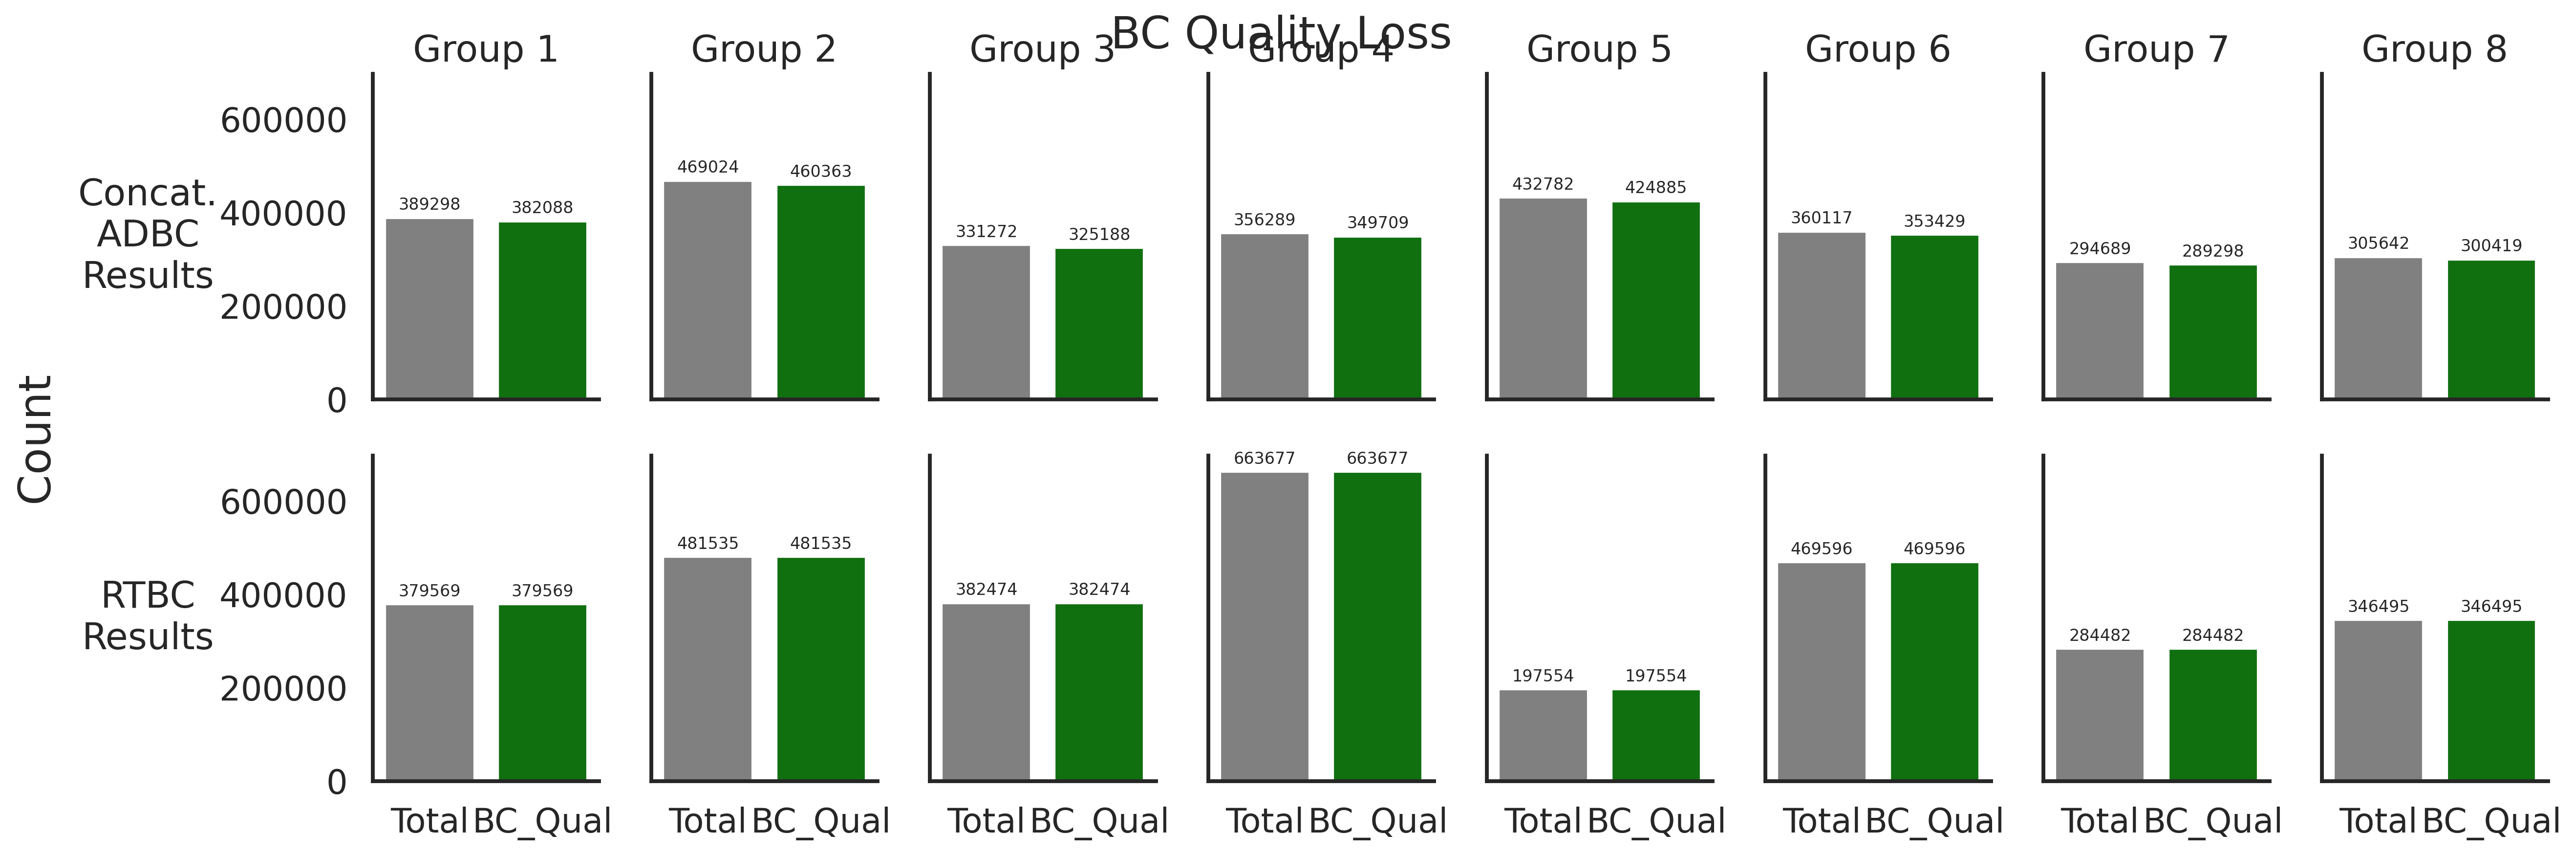

In [188]:
fig, axes = plt.subplots(2, 8, figsize=(18,6), dpi=300, sharey=True, sharex = True)
axes = axes.flatten()  # flatten to index easily 0..15

# First row: AD (ADBC/HawkBCs)
for i in np.arange(1, 9):
    file_name = f'umi_a{i}_RNA_ADBC_S{16 + i}_ADBC2_HawkBCs_initial'
    df = refiner.get_map_df(file_name)
    
    total_count = len(df)
    both_true = ((df["ADBC2_qual"]) & (df["HawkBCs_qual"])).sum()
    
    plot_counts = pd.DataFrame({
        "Category": ["Total", "BC_Qual"],
        "Count": [total_count, both_true]
    })
    
    ax = axes[i-1]
    bars = sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=["gray", "green"])
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=8, padding=2)
    
    ax.set_title("Group " + str(file_name[:6][-1]), fontsize='medium')
    ax.set_xlabel("")
    ax.set_ylabel("")

# Second row: RPTR (RTBC)
for i in np.arange(1, 9):
    file_name = f'umi_r{i}_RNA_RTBC_S{24 + i}_RTBC_initial'
    df = refiner.get_map_df(file_name)
    
    total_count = len(df)
    true_count = df["RTBC_qual"].sum()  # assuming boolean True/False
    
    plot_counts = pd.DataFrame({
        "Category": ["Total", "BC_Qual"],
        "Count": [total_count, true_count]
    })
    
    ax = axes[8 + i-1]  # second row: indices 8..15
    bars = sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=["gray", "green"])
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=8, padding=2)
    
    #ax.set_title(file_name[:6], fontsize='medium')
    ax.set_xlabel("")
    ax.set_ylabel("")

axes[0].set_ylabel("Concat.\nADBC\nResults", rotation = 0, labelpad = 35, va = 'center')
axes[8].set_ylabel("RTBC\nResults", rotation = 0, labelpad = 35, va = 'center')

fig.supylabel("Count")
sns.despine()
plt.tight_layout(pad = 1)
fig.suptitle("BC Quality Loss")
plt.savefig(os.path.join(output_path, f"bc_quality_loss.png"))
plt.show()

In [189]:
i = 1
file_name = f'umi_a{i}_RNA_ADBC_S{16 + i}_ADBC2_HawkBCs_initial'
df = refiner.get_map_df(file_name)
ADBC2_nulls = len(df[df["ADBC2"] == ""])
ADBC2_wrong_len = len(df[(df["ADBC2"] != "") & (df["ADBC2"].str.len() != 6)])
ADBC2_qual = len(df[df["ADBC2_qual"]])

HawkBCs_nulls = len(df[df["HawkBCs"] == ""])
HawkBCs_wrong_len = len(df[(df["HawkBCs"] != "") & (df["HawkBCs"].str.len() != 9)])
HawkBCs_qual = len(df[df["HawkBCs_qual"]])

both_good = len(df[(df["HawkBCs_qual"] == True) & (df["ADBC2_qual"] == True)])
df
# total_count = len(df)
# both_true = ((df["ADBC2_qual"]) & (df["HawkBCs_qual"])).sum()

# plot_counts = pd.DataFrame({
#     "Category": ["Total", "BC_Qual"],
#     "Count": [total_count, both_true]
# })

# ax = axes[i-1]
# bars = sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=["gray", "green"])

# for container in ax.containers:
#     ax.bar_label(container, fmt='%d', label_type='edge', fontsize=8, padding=2)

# ax.set_title("Group " + str(file_name[:6][-1]), fontsize='medium')
# ax.set_xlabel("")
# ax.set_ylabel("")

ADBC2  ADBC2_qual    HawkBCs  HawkBCs_qual           UMI  Designed
0       GTACAA        True  CCATCGGTT          True  GTTAGGCGATTA         1
1       GGTGCT        True  CAACTACAG          True  TAAACACGCGAA         1
2       ATGATC        True  CAATCTCTC          True  GTGACTAGATGG         1
3       GAGAAG        True  CAGATCGTT          True  ACCCGTTGAGCG         1
4       AAGCAG        True  CATCCTGTC          True  TAGTGCTTAGCA         1
...        ...         ...        ...           ...           ...       ...
389293  AAAGTT        True  CATGTTGCC          True  CGACTCCGGCTC         1
389294  CAGGTA        True  CACAACTTC          True  ATGATAAACTTG         1
389295  CTACGG        True  CATACGATC          True  CGCCCCAACCAC         1
389296  CTATAA        True  CACGAGATC          True  CAACAGGATTAA         1
389297  GTAGGT        True  CAGACAGCA          True  TTAACACTATTT         1

[389298 rows x 6 columns]

In [190]:
# fig, ax = plt.subplots(figsize=(4, 6), dpi=150)

# rep_labels = []
# segments = {"Nulls": [], "Wrong Length": [], "Valid": []}  # order

# bar_height = 0.2  # height of each small segment
# y_pos = np.arange(8)  # center y-position for each replicate

# for i in np.arange(1, 9):
#     file_name = f'umi_r{i}_RNA_RTBC_S{24 + i}_RTBC_initial'
#     df = refiner.get_map_df(file_name)
    
#     # Compute counts
#     num_nulls = len(df[df["RTBC"] == ""])
#     len_wrong_length = len(df[(df["RTBC"] != "") & (df["RTBC"].str.len() != 16)])
#     len_qual = len(df[df["RTBC_qual"]])
    
#     rep_labels.append(f"R{i}")
#     segments["Nulls"].append(num_nulls)
#     segments["Wrong Length"].append(len_wrong_length)
#     segments["Valid"].append(len_qual)

# # Colors
# category_colors = {"Nulls": "maroon", "Wrong Length": "red", "Valid": "green"}

# # Offsets for top → middle → bottom stacking
# offsets = {"Nulls": bar_height, "Wrong Length": 0, "Valid": -bar_height}

# # Plot each segment
# for seg_name in ["Nulls", "Wrong Length", "Valid"]:
#     ax.barh(y_pos + offsets[seg_name], segments[seg_name], height=bar_height,
#             color=category_colors[seg_name], edgecolor="none", label=seg_name)
    
#     # Add labels to the right of each segment
#     for y, val in zip(y_pos + offsets[seg_name], segments[seg_name]):
#         if val > 0:
#             ax.text(val + 5, y, str(val), va='center', ha='left', color=category_colors[seg_name], fontsize=9)

# # Y-axis ticks
# ax.set_yticks(y_pos)
# ax.set_yticklabels(rep_labels)

# ax.set_xlabel("Count")
# ax.set_title("RTBC Loss")
# ax.legend(title="Category", loc = 'upper right', bbox_to_anchor = (2,1))
# sns.despine(bottom=True)
# plt.tight_layout()
# plt.show()

# Reads per UMI

In [191]:
ADBC_reads_per_umi = []

for file_path in AD_seq_files:
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0]
    print(name_only) 

    # Run both deduplications
    deduplicator = umi_deduplicate.UMIDeduplicator(db_path = db_path,
                                                        bc_objects = AD_objects,
                                                        step_name = f"umi_{name_only}", 
                                                        descriptor = "",
                                                        step1_map_name = None,
                                                        fastq_path = file_path,
                                                        umi_length = 12,
                                                        output_path = umi_path)

    one_file_reads_per_UMI = deduplicator.counts_per_umi()
    one_file_reads_per_UMI["name"] = name_only
    ADBC_reads_per_umi.append(one_file_reads_per_UMI)
    
ADBC_reads_per_umi = pd.concat(ADBC_reads_per_umi)
ADBC_reads_per_umi

a2_RNA_ADBC_S18
a7_RNA_ADBC_S23
a1_RNA_ADBC_S17
a3_RNA_ADBC_S19
a6_RNA_ADBC_S22
a4_RNA_ADBC_S20
a8_RNA_ADBC_S24
a5_RNA_ADBC_S21


ADBC2    HawkBCs           UMI  reads             name
0       AAAAAA  CCATCGGTT  TTGAACAACCGC      2  a2_RNA_ADBC_S18
1       AAAAAC  CACAACTTC  GGAATGGAAAGT      1  a2_RNA_ADBC_S18
2       AAAAAC  CACAACTTC  TGTCCCCCTCAG      1  a2_RNA_ADBC_S18
3       AAAAAC  CACAAGGAC  CTAGATGTGTTG      1  a2_RNA_ADBC_S18
4       AAAAAG  CAATCTCTC  TTAATTCTTTGC      1  a2_RNA_ADBC_S18
...        ...        ...           ...    ...              ...
311335  TTTTGC  ATACCGTCG  TAAGAGATGGGC      1  a5_RNA_ADBC_S21
311336  TTTTGC  ATACCGTCG  TCAATTGAAAAT      1  a5_RNA_ADBC_S21
311337  TTTTGC  CAACGCTTC  TCTGTGACAACA      1  a5_RNA_ADBC_S21
311338  TTTTGC  CAACGCTTC  TACTAATCAAGG      1  a5_RNA_ADBC_S21
311339  TTTTGT  ATACCGTCG  AAAAGCAAGGGG      1  a5_RNA_ADBC_S21

[2210919 rows x 5 columns]

In [192]:
ADBC_reads_per_umi.to_csv(os.path.join(output_path, f"ADBC_reads_per_umi.csv"))

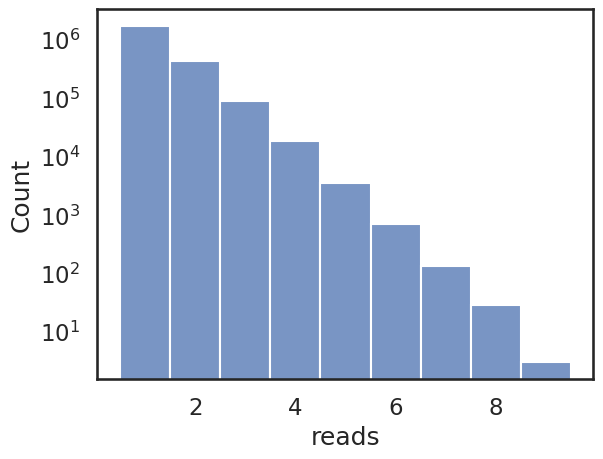

In [198]:
ax = sns.histplot(ADBC_reads_per_umi['reads'], discrete = True)
ax.set_yscale('log')

In [193]:
RTBC_reads_per_umi = []
for file_path in RT_seq_files:
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0]
    print(name_only) 

    # Run both deduplications
    deduplicator = umi_deduplicate.UMIDeduplicator(db_path = db_path,
                                                        bc_objects = RTBC_objects,
                                                        step_name = f"umi_{name_only}", 
                                                        descriptor = "",
                                                        step1_map_name = None,
                                                        fastq_path = file_path,
                                                        umi_length = 12,
                                                        output_path = umi_path)

    one_file_reads_per_UMI = deduplicator.counts_per_umi()
    one_file_reads_per_UMI["name"] = name_only
    RTBC_reads_per_umi.append(one_file_reads_per_UMI)
RTBC_reads_per_umi = pd.concat(RTBC_reads_per_umi)
RTBC_reads_per_umi

r2_RNA_RTBC_S26
r8_RNA_RTBC_S32
r7_RNA_RTBC_S31
r1_RNA_RTBC_S25
r6_RNA_RTBC_S30
r3_RNA_RTBC_S27
r5_RNA_RTBC_S29
r4_RNA_RTBC_S28


RTBC           UMI  reads             name
0       AAAATTATTGAGAAGC  GCCCCCCAAAAC      6  r2_RNA_RTBC_S26
1       AAAATTATTGAGAAGC  ATGCTGAACAAA      6  r2_RNA_RTBC_S26
2       AAAATTATTGAGAAGC  TATATCTATCAC      6  r2_RNA_RTBC_S26
3       AAAATTATTGAGAAGC  TCACGTCGATAC      5  r2_RNA_RTBC_S26
4       AAAATTATTGAGAAGC  CACATAGTTCTA      5  r2_RNA_RTBC_S26
...                  ...           ...    ...              ...
437771  TTTCTAATTCAACATC  GATCTATGAATA      1  r4_RNA_RTBC_S28
437772  TTTCTAATTCAACATC  CTTCGTCTTAGA      1  r4_RNA_RTBC_S28
437773  TTTCTAATTCAACATC  AGGCTTCCTGAT      1  r4_RNA_RTBC_S28
437774  TTTCTAATTCAACATC  ATGCCCAGCTAT      1  r4_RNA_RTBC_S28
437775  TTTCTAATTCAACATC  AGCATCGAGATT      1  r4_RNA_RTBC_S28

[2109408 rows x 4 columns]

In [194]:
RTBC_reads_per_umi.to_csv(os.path.join(output_path, f"RTBC_reads_per_umi.csv"))

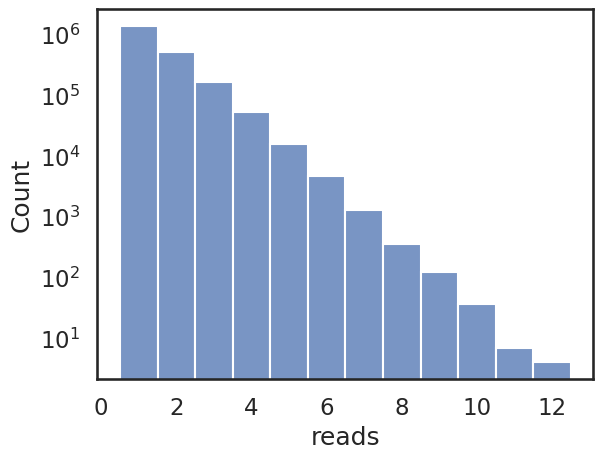

In [197]:
ax = sns.histplot(RTBC_reads_per_umi['reads'], discrete = True)
ax.set_yscale('log')